# XGBoost

## Loading data and selecting features of interest

In [ ]:
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import numpy as np

from pyarrow import Table
from pandas import DataFrame, api, Int64Dtype
from pandas.core.dtypes import common as com
import sys
sys.path.append('..')
from utils.preprocess import NDF

def cast_timestamp(df: DataFrame):
    """
    Cast timestamp fields to seconds since epoch.
    """
    for col in df.columns:
        if com.is_timedelta64_dtype(df[col]):
            df[col] = df[col].dt.total_seconds()  # This converts timedelta to float (seconds)
        elif com.is_datetime64_any_dtype(df[col]):
            df[col] = df[col].astype(np.int64) // 10**9  # Converts datetime64 to Unix timestamp (seconds)

    return df

def union_tables(tables: [pa.Table]) -> pa.Table:
    union_table = tables[0]
    for table in tables[1:]:
        right_not_in_union = union_table.join(right_table=table, keys='domain_name', join_type='right anti',
                                              coalesce_keys=True, use_threads=True)
        union_table = pa.concat_tables([union_table, right_not_in_union])
    return union_table

# #############################################################
# EDIT this to specify benign / malicious datasets to use     #
# #############################################################
benign_dataset_filenames = [
    '../feature-extraction/floor/benign_2312.parquet',
    '../feature-extraction/floor/umbrella_benign_FINISHED.parquet'
]
malicious_dataset_filenames = [
    '../feature-extraction/floor/malware_bp.parquet',
]
# #############################################################
benign_label = "benign"
malicious_label = "malware"
# #############################################################

# Unify malicious datasets and benign datasets
schema = (pq.read_table(malicious_dataset_filenames[0])).schema # Use the schema from the first malicious filename
benign_tables = [pq.read_table(filename).cast(schema) for filename in benign_dataset_filenames]

malicious_tables = [pq.read_table(filename).cast(schema) for filename in malicious_dataset_filenames]
malicious = union_tables(malicious_tables)
benign = union_tables(benign_tables)

# Convert pyarrow tables to pandas dataframes
df_benign = benign.to_pandas()
df_malicious = malicious.to_pandas()

# Set appropriate labels
df_benign["label"] = benign_label
df_malicious["label"] = malicious_label
class_map = {benign_label: 0, malicious_label: 1}

# Merge them together and create NDF

# Store them for future use (e.g. creating NDF)
df_benign.to_parquet('temp/benign_merged.parquet')
df_malicious.to_parquet('temp/malicious_merged.parquet')

from utils.preprocess import NDF
input_data = {
    'benign': 'temp/benign_merged.parquet',
    'malign': 'temp/malicious_merged.parquet'
}
ndf_dataset = NDF("malware", True, input_data=input_data, one_line_processing=False)


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
2024-06-04 16:27:20,696 - utils.preprocess - INFO - Benign dataset path: temp/benign_merged.parquet
2024-06-04 16:27:20,697 - utils.preprocess - INFO - Malign dataset path: temp/malicious_merged.parquet
2024-06-04 16:27:21,213 - utils.preprocess - INFO - Number of records in combined dataset: 947250


# Model Validation Function

In [35]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, log_loss, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from kneed import KneeLocator

# Helpers
from kneed import KneeLocator

def plot_metric(metric):
    plt.rcParams["figure.dpi"] = 300
    
    # Plot metric curves
    plt.plot(x_axis, results['training'][metric], label='Training set')
    plt.plot(x_axis, results['valid_1'][metric], label='Testing set')
    
    # Detect elbow using Kneedle algorithm
    kn = KneeLocator(x_axis, results['valid_1'][metric], curve='convex', direction='decreasing')
    if kn.knee:
        plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red', label='Elbow at tree ' + str(kn.knee))
    
    plt.legend()
    mnames = {'error': 'Classification Error', 'binary_logloss': 'Log Loss', 'auc': 'AUC'}
    mname = mnames.get(metric, metric)  # Return the metric itself if it's not in the dictionary
    plt.ylabel(mname)
    plt.xlabel('Number of trees')
    plt.title('LightGBM ' + mname)
    plt.show()

    
# Tuning - graphs
def DisplayTuningGraph(scores):
    from numpy import array
    from numpy.ma import masked_array

    col_names = ['mean_train_score', 'mean_test_score']
    means_df = scores[col_names]
    ax = means_df.plot(kind='line', grid=True)

    from matplotlib import pyplot as plt
    plt.rcParams["figure.figsize"] = [12, 12]
    plt.rcParams["figure.autolayout"] = True

    plt.rcParams["figure.dpi"] = 300

    max_ids = means_df.idxmax(axis=0)

    for i in range(len(max_ids)):
        for col_name in col_names:
            value = means_df[col_name][max_ids[i]]
            id = max_ids[i]

            color = 'r' if max_ids[i] == max_ids['mean_test_score'] else 'grey'

            ax.scatter([id], [value],
                      marker='o',
                      color=color,
                      label='point',)

            ax.annotate(str(round(value, 3))+"_ID="+str(id),
                        (id, value),
                        xytext=(id+3, value))
    print(scores)

def ValidateModel_advanced(X_test, y_test, model): 
    y_pred = model.predict(X_test)
    
    # Classification report
    print(classification_report(y_test, y_pred, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    tn, fp, fn, tp = cm.ravel()
    print("Confusion Matrix:")
    print("TN:", tn, "FP:", fp, "FN:", fn, "TP:", tp)

    # Plotting ROC Curve
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Model-specific evaluations
    if isinstance(model, (XGBClassifier, LGBMClassifier)):
        
        if isinstance(model, (XGBClassifier)):
            results = model.evals_result()
        elif isinstance(model, (LGBMClassifier)):
            results = model.evals_result_

        training_key = 'training' if isinstance(model, LGBMClassifier) else 'validation_0'
        validation_key = 'valid_1' if isinstance(model, LGBMClassifier) else 'validation_1'
        
        print("Training metrics:", results[training_key].keys())
        print("Validation metrics:", results[validation_key].keys())

        trees = len(results[validation_key]['binary_logloss']) if isinstance(model, LGBMClassifier) else len(results[validation_key]['logloss'])
        x_axis = range(0, trees)

        def plot_metric(metric):
            plt.rcParams["figure.dpi"] = 300

            # Plot metric curves
            plt.plot(x_axis, results[training_key][metric], label='Training set')
            plt.plot(x_axis, results[validation_key][metric], label='Validation set')

            # Detect elbow using Kneedle algorithm
            kn = KneeLocator(x_axis, results[validation_key][metric], curve='convex', direction='decreasing')
            if kn.knee:
                plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red', label='Elbow at tree ' + str(kn.knee))

            plt.legend()
            mnames = {'binary_logloss': 'Log Loss', 'auc': 'AUC'}
            mname = mnames.get(metric, metric)
            plt.ylabel(mname)
            plt.xlabel('Number of trees')
            plt.title(f'{type(model).__name__} {mname}')
            plt.show()

        if isinstance(model, LGBMClassifier):
            plot_metric('binary_logloss')
        elif isinstance(model, XGBClassifier):
            plot_metric('logloss')
            
        plot_metric('auc')
        
    elif isinstance(model, (RandomForestClassifier, AdaBoostClassifier)):
        # For RandomForest and AdaBoost, additional model-specific evaluations can be added here
        pass
    
    # Display the confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)  # Compute confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)  # Create display object
    disp.plot(cmap=plt.cm.Blues)  # Plot confusion matrix
    plt.show()  # Show the plot

In [36]:
# Check if the NDF contains corresponding number of classes

# Assuming ndf_dataset is a DataFrame with 'features' and 'labels' columns
X = np.array(ndf_dataset['features'].tolist())
Y = np.array(ndf_dataset['labels'].tolist())

# Check unique values in labels
unique_labels = np.unique(Y)
print(f"Unique labels: {unique_labels}")

# Ensure binary classification
assert len(unique_labels) == 2, "The problem is not binary classification."

Unique labels: [0. 1.]


## Supressing unwanted warnings (futures etc.)

In [37]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn.*')
warnings.filterwarnings('ignore', category=FutureWarning, module='xgboost.*')
warnings.filterwarnings('ignore', message="Series.__getitem__ treating keys as positions is deprecated.*")

# Train-Test Split

In [38]:
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module="sklearn")

X_train, X_test, Y_train, Y_test = train_test_split(  
  np.array(ndf_dataset['features']),
  np.array(ndf_dataset['labels']),
  test_size=0.2,
  random_state=42
)

# XGBoost

In [39]:
import joblib
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# XGBoost parameters
params = {        
    "objective": "binary:logistic",
    "tree_method": "gpu_hist",
    "sampling_method": "gradient_based",
    "max_depth": 12, 
    "eta": 0.09787878787878787, 
    "min_child_weight": 1, 
    "subsample": 0.595959595959596, 
    "alpha": 0, 
    "gamma": 0.06060606060606061, 
    "lambda": 2.0707070707070705, 
    "max_delta_step": 0, 
    "grow_policy": "depthwise",
    "max_bin": 512,
    "n_estimators": 600, 
    #"scale_pos_weight": scale_pos_weight,
    "random_state": 42  # Set the seed for each run
}

# Create the XGBoost model
model = xgb.XGBClassifier(**params)

# Train the model
eval_set = [(X_train, Y_train), (X_test, Y_test)]
model.fit(X_train, Y_train, eval_set=eval_set, eval_metric=["error", "logloss", "auc"])

# Save the model to a file
joblib.dump(model, 'models/malware_xgboost_model.joblib')

[0]	validation_0-error:0.14095	validation_0-logloss:0.34824	validation_0-auc:0.99689	validation_1-error:0.14156	validation_1-logloss:0.34941	validation_1-auc:0.99619
[1]	validation_0-error:0.14095	validation_0-logloss:0.30184	validation_0-auc:0.99744	validation_1-error:0.14156	validation_1-logloss:0.30331	validation_1-auc:0.99684
[2]	validation_0-error:0.14095	validation_0-logloss:0.26564	validation_0-auc:0.99765	validation_1-error:0.14156	validation_1-logloss:0.26730	validation_1-auc:0.99708
[3]	validation_0-error:0.14095	validation_0-logloss:0.23619	validation_0-auc:0.99778	validation_1-error:0.14156	validation_1-logloss:0.23807	validation_1-auc:0.99722
[4]	validation_0-error:0.02574	validation_0-logloss:0.21137	validation_0-auc:0.99803	validation_1-error:0.02653	validation_1-logloss:0.21349	validation_1-auc:0.99746
[5]	validation_0-error:0.01775	validation_0-logloss:0.19016	validation_0-auc:0.99810	validation_1-error:0.01909	validation_1-logloss:0.19248	validation_1-auc:0.99755
[6]	

[49]	validation_0-error:0.00595	validation_0-logloss:0.01985	validation_0-auc:0.99960	validation_1-error:0.00947	validation_1-logloss:0.02903	validation_1-auc:0.99875
[50]	validation_0-error:0.00589	validation_0-logloss:0.01952	validation_0-auc:0.99961	validation_1-error:0.00943	validation_1-logloss:0.02880	validation_1-auc:0.99876
[51]	validation_0-error:0.00586	validation_0-logloss:0.01926	validation_0-auc:0.99962	validation_1-error:0.00944	validation_1-logloss:0.02862	validation_1-auc:0.99876
[52]	validation_0-error:0.00583	validation_0-logloss:0.01894	validation_0-auc:0.99963	validation_1-error:0.00943	validation_1-logloss:0.02837	validation_1-auc:0.99878
[53]	validation_0-error:0.00576	validation_0-logloss:0.01862	validation_0-auc:0.99964	validation_1-error:0.00940	validation_1-logloss:0.02812	validation_1-auc:0.99879
[54]	validation_0-error:0.00570	validation_0-logloss:0.01832	validation_0-auc:0.99966	validation_1-error:0.00939	validation_1-logloss:0.02788	validation_1-auc:0.9988

[98]	validation_0-error:0.00441	validation_0-logloss:0.01316	validation_0-auc:0.99984	validation_1-error:0.00886	validation_1-logloss:0.02446	validation_1-auc:0.99911
[99]	validation_0-error:0.00440	validation_0-logloss:0.01314	validation_0-auc:0.99984	validation_1-error:0.00884	validation_1-logloss:0.02444	validation_1-auc:0.99912
[100]	validation_0-error:0.00436	validation_0-logloss:0.01307	validation_0-auc:0.99984	validation_1-error:0.00884	validation_1-logloss:0.02439	validation_1-auc:0.99912
[101]	validation_0-error:0.00434	validation_0-logloss:0.01301	validation_0-auc:0.99984	validation_1-error:0.00883	validation_1-logloss:0.02436	validation_1-auc:0.99912
[102]	validation_0-error:0.00434	validation_0-logloss:0.01297	validation_0-auc:0.99984	validation_1-error:0.00884	validation_1-logloss:0.02434	validation_1-auc:0.99912
[103]	validation_0-error:0.00433	validation_0-logloss:0.01294	validation_0-auc:0.99984	validation_1-error:0.00883	validation_1-logloss:0.02432	validation_1-auc:0.

[146]	validation_0-error:0.00348	validation_0-logloss:0.01072	validation_0-auc:0.99990	validation_1-error:0.00847	validation_1-logloss:0.02344	validation_1-auc:0.99920
[147]	validation_0-error:0.00346	validation_0-logloss:0.01067	validation_0-auc:0.99990	validation_1-error:0.00847	validation_1-logloss:0.02344	validation_1-auc:0.99920
[148]	validation_0-error:0.00346	validation_0-logloss:0.01063	validation_0-auc:0.99990	validation_1-error:0.00847	validation_1-logloss:0.02341	validation_1-auc:0.99920
[149]	validation_0-error:0.00344	validation_0-logloss:0.01057	validation_0-auc:0.99991	validation_1-error:0.00847	validation_1-logloss:0.02340	validation_1-auc:0.99920
[150]	validation_0-error:0.00339	validation_0-logloss:0.01048	validation_0-auc:0.99991	validation_1-error:0.00847	validation_1-logloss:0.02339	validation_1-auc:0.99920
[151]	validation_0-error:0.00334	validation_0-logloss:0.01043	validation_0-auc:0.99991	validation_1-error:0.00845	validation_1-logloss:0.02339	validation_1-auc:

[194]	validation_0-error:0.00271	validation_0-logloss:0.00888	validation_0-auc:0.99994	validation_1-error:0.00830	validation_1-logloss:0.02301	validation_1-auc:0.99923
[195]	validation_0-error:0.00271	validation_0-logloss:0.00885	validation_0-auc:0.99994	validation_1-error:0.00829	validation_1-logloss:0.02302	validation_1-auc:0.99923
[196]	validation_0-error:0.00271	validation_0-logloss:0.00884	validation_0-auc:0.99994	validation_1-error:0.00831	validation_1-logloss:0.02302	validation_1-auc:0.99923
[197]	validation_0-error:0.00270	validation_0-logloss:0.00879	validation_0-auc:0.99994	validation_1-error:0.00828	validation_1-logloss:0.02299	validation_1-auc:0.99924
[198]	validation_0-error:0.00270	validation_0-logloss:0.00877	validation_0-auc:0.99994	validation_1-error:0.00828	validation_1-logloss:0.02297	validation_1-auc:0.99924
[199]	validation_0-error:0.00268	validation_0-logloss:0.00875	validation_0-auc:0.99994	validation_1-error:0.00829	validation_1-logloss:0.02297	validation_1-auc:

[242]	validation_0-error:0.00206	validation_0-logloss:0.00747	validation_0-auc:0.99996	validation_1-error:0.00809	validation_1-logloss:0.02282	validation_1-auc:0.99926
[243]	validation_0-error:0.00206	validation_0-logloss:0.00746	validation_0-auc:0.99996	validation_1-error:0.00810	validation_1-logloss:0.02282	validation_1-auc:0.99926
[244]	validation_0-error:0.00204	validation_0-logloss:0.00744	validation_0-auc:0.99996	validation_1-error:0.00810	validation_1-logloss:0.02282	validation_1-auc:0.99926
[245]	validation_0-error:0.00198	validation_0-logloss:0.00735	validation_0-auc:0.99997	validation_1-error:0.00814	validation_1-logloss:0.02281	validation_1-auc:0.99926
[246]	validation_0-error:0.00194	validation_0-logloss:0.00732	validation_0-auc:0.99997	validation_1-error:0.00814	validation_1-logloss:0.02281	validation_1-auc:0.99926
[247]	validation_0-error:0.00190	validation_0-logloss:0.00723	validation_0-auc:0.99997	validation_1-error:0.00818	validation_1-logloss:0.02282	validation_1-auc:

[290]	validation_0-error:0.00136	validation_0-logloss:0.00608	validation_0-auc:0.99998	validation_1-error:0.00806	validation_1-logloss:0.02285	validation_1-auc:0.99927
[291]	validation_0-error:0.00136	validation_0-logloss:0.00605	validation_0-auc:0.99998	validation_1-error:0.00806	validation_1-logloss:0.02285	validation_1-auc:0.99927
[292]	validation_0-error:0.00135	validation_0-logloss:0.00603	validation_0-auc:0.99998	validation_1-error:0.00806	validation_1-logloss:0.02286	validation_1-auc:0.99927
[293]	validation_0-error:0.00135	validation_0-logloss:0.00601	validation_0-auc:0.99998	validation_1-error:0.00802	validation_1-logloss:0.02286	validation_1-auc:0.99927
[294]	validation_0-error:0.00135	validation_0-logloss:0.00601	validation_0-auc:0.99998	validation_1-error:0.00804	validation_1-logloss:0.02286	validation_1-auc:0.99927
[295]	validation_0-error:0.00133	validation_0-logloss:0.00597	validation_0-auc:0.99998	validation_1-error:0.00803	validation_1-logloss:0.02286	validation_1-auc:

[338]	validation_0-error:0.00088	validation_0-logloss:0.00498	validation_0-auc:0.99999	validation_1-error:0.00804	validation_1-logloss:0.02293	validation_1-auc:0.99928
[339]	validation_0-error:0.00088	validation_0-logloss:0.00498	validation_0-auc:0.99999	validation_1-error:0.00805	validation_1-logloss:0.02294	validation_1-auc:0.99928
[340]	validation_0-error:0.00088	validation_0-logloss:0.00497	validation_0-auc:0.99999	validation_1-error:0.00806	validation_1-logloss:0.02293	validation_1-auc:0.99928
[341]	validation_0-error:0.00085	validation_0-logloss:0.00492	validation_0-auc:0.99999	validation_1-error:0.00810	validation_1-logloss:0.02294	validation_1-auc:0.99928
[342]	validation_0-error:0.00085	validation_0-logloss:0.00491	validation_0-auc:0.99999	validation_1-error:0.00808	validation_1-logloss:0.02295	validation_1-auc:0.99928
[343]	validation_0-error:0.00084	validation_0-logloss:0.00489	validation_0-auc:0.99999	validation_1-error:0.00805	validation_1-logloss:0.02296	validation_1-auc:

[386]	validation_0-error:0.00057	validation_0-logloss:0.00413	validation_0-auc:1.00000	validation_1-error:0.00803	validation_1-logloss:0.02311	validation_1-auc:0.99929
[387]	validation_0-error:0.00057	validation_0-logloss:0.00413	validation_0-auc:1.00000	validation_1-error:0.00801	validation_1-logloss:0.02311	validation_1-auc:0.99929
[388]	validation_0-error:0.00056	validation_0-logloss:0.00411	validation_0-auc:1.00000	validation_1-error:0.00801	validation_1-logloss:0.02312	validation_1-auc:0.99929
[389]	validation_0-error:0.00056	validation_0-logloss:0.00410	validation_0-auc:1.00000	validation_1-error:0.00803	validation_1-logloss:0.02313	validation_1-auc:0.99929
[390]	validation_0-error:0.00056	validation_0-logloss:0.00409	validation_0-auc:1.00000	validation_1-error:0.00803	validation_1-logloss:0.02313	validation_1-auc:0.99929
[391]	validation_0-error:0.00056	validation_0-logloss:0.00407	validation_0-auc:1.00000	validation_1-error:0.00803	validation_1-logloss:0.02314	validation_1-auc:

[434]	validation_0-error:0.00033	validation_0-logloss:0.00338	validation_0-auc:1.00000	validation_1-error:0.00811	validation_1-logloss:0.02335	validation_1-auc:0.99930
[435]	validation_0-error:0.00032	validation_0-logloss:0.00337	validation_0-auc:1.00000	validation_1-error:0.00808	validation_1-logloss:0.02335	validation_1-auc:0.99930
[436]	validation_0-error:0.00030	validation_0-logloss:0.00333	validation_0-auc:1.00000	validation_1-error:0.00806	validation_1-logloss:0.02335	validation_1-auc:0.99930
[437]	validation_0-error:0.00030	validation_0-logloss:0.00332	validation_0-auc:1.00000	validation_1-error:0.00806	validation_1-logloss:0.02336	validation_1-auc:0.99930
[438]	validation_0-error:0.00029	validation_0-logloss:0.00331	validation_0-auc:1.00000	validation_1-error:0.00808	validation_1-logloss:0.02337	validation_1-auc:0.99930
[439]	validation_0-error:0.00029	validation_0-logloss:0.00329	validation_0-auc:1.00000	validation_1-error:0.00810	validation_1-logloss:0.02338	validation_1-auc:

[482]	validation_0-error:0.00020	validation_0-logloss:0.00288	validation_0-auc:1.00000	validation_1-error:0.00809	validation_1-logloss:0.02361	validation_1-auc:0.99931
[483]	validation_0-error:0.00020	validation_0-logloss:0.00287	validation_0-auc:1.00000	validation_1-error:0.00808	validation_1-logloss:0.02362	validation_1-auc:0.99931
[484]	validation_0-error:0.00020	validation_0-logloss:0.00287	validation_0-auc:1.00000	validation_1-error:0.00806	validation_1-logloss:0.02362	validation_1-auc:0.99931
[485]	validation_0-error:0.00019	validation_0-logloss:0.00285	validation_0-auc:1.00000	validation_1-error:0.00807	validation_1-logloss:0.02363	validation_1-auc:0.99931
[486]	validation_0-error:0.00019	validation_0-logloss:0.00283	validation_0-auc:1.00000	validation_1-error:0.00801	validation_1-logloss:0.02363	validation_1-auc:0.99931
[487]	validation_0-error:0.00019	validation_0-logloss:0.00282	validation_0-auc:1.00000	validation_1-error:0.00801	validation_1-logloss:0.02364	validation_1-auc:

[530]	validation_0-error:0.00010	validation_0-logloss:0.00244	validation_0-auc:1.00000	validation_1-error:0.00806	validation_1-logloss:0.02389	validation_1-auc:0.99931
[531]	validation_0-error:0.00010	validation_0-logloss:0.00243	validation_0-auc:1.00000	validation_1-error:0.00805	validation_1-logloss:0.02389	validation_1-auc:0.99931
[532]	validation_0-error:0.00010	validation_0-logloss:0.00242	validation_0-auc:1.00000	validation_1-error:0.00805	validation_1-logloss:0.02390	validation_1-auc:0.99931
[533]	validation_0-error:0.00010	validation_0-logloss:0.00242	validation_0-auc:1.00000	validation_1-error:0.00805	validation_1-logloss:0.02390	validation_1-auc:0.99931
[534]	validation_0-error:0.00010	validation_0-logloss:0.00241	validation_0-auc:1.00000	validation_1-error:0.00804	validation_1-logloss:0.02390	validation_1-auc:0.99931
[535]	validation_0-error:0.00010	validation_0-logloss:0.00241	validation_0-auc:1.00000	validation_1-error:0.00805	validation_1-logloss:0.02390	validation_1-auc:

[578]	validation_0-error:0.00009	validation_0-logloss:0.00226	validation_0-auc:1.00000	validation_1-error:0.00801	validation_1-logloss:0.02403	validation_1-auc:0.99931
[579]	validation_0-error:0.00009	validation_0-logloss:0.00226	validation_0-auc:1.00000	validation_1-error:0.00801	validation_1-logloss:0.02403	validation_1-auc:0.99931
[580]	validation_0-error:0.00009	validation_0-logloss:0.00226	validation_0-auc:1.00000	validation_1-error:0.00801	validation_1-logloss:0.02403	validation_1-auc:0.99931
[581]	validation_0-error:0.00009	validation_0-logloss:0.00226	validation_0-auc:1.00000	validation_1-error:0.00801	validation_1-logloss:0.02403	validation_1-auc:0.99931
[582]	validation_0-error:0.00009	validation_0-logloss:0.00226	validation_0-auc:1.00000	validation_1-error:0.00801	validation_1-logloss:0.02403	validation_1-auc:0.99931
[583]	validation_0-error:0.00009	validation_0-logloss:0.00226	validation_0-auc:1.00000	validation_1-error:0.00801	validation_1-logloss:0.02403	validation_1-auc:

['models/malware_xgboost_model.joblib']

## XGBoost Model Validation

              precision    recall  f1-score   support

         0.0     0.9948    0.9959    0.9953    149093
         1.0     0.9750    0.9682    0.9716     24585

    accuracy                         0.9920    173678
   macro avg     0.9849    0.9821    0.9835    173678
weighted avg     0.9920    0.9920    0.9920    173678

Confusion Matrix:
TN: 148483 FP: 610 FN: 782 TP: 23803


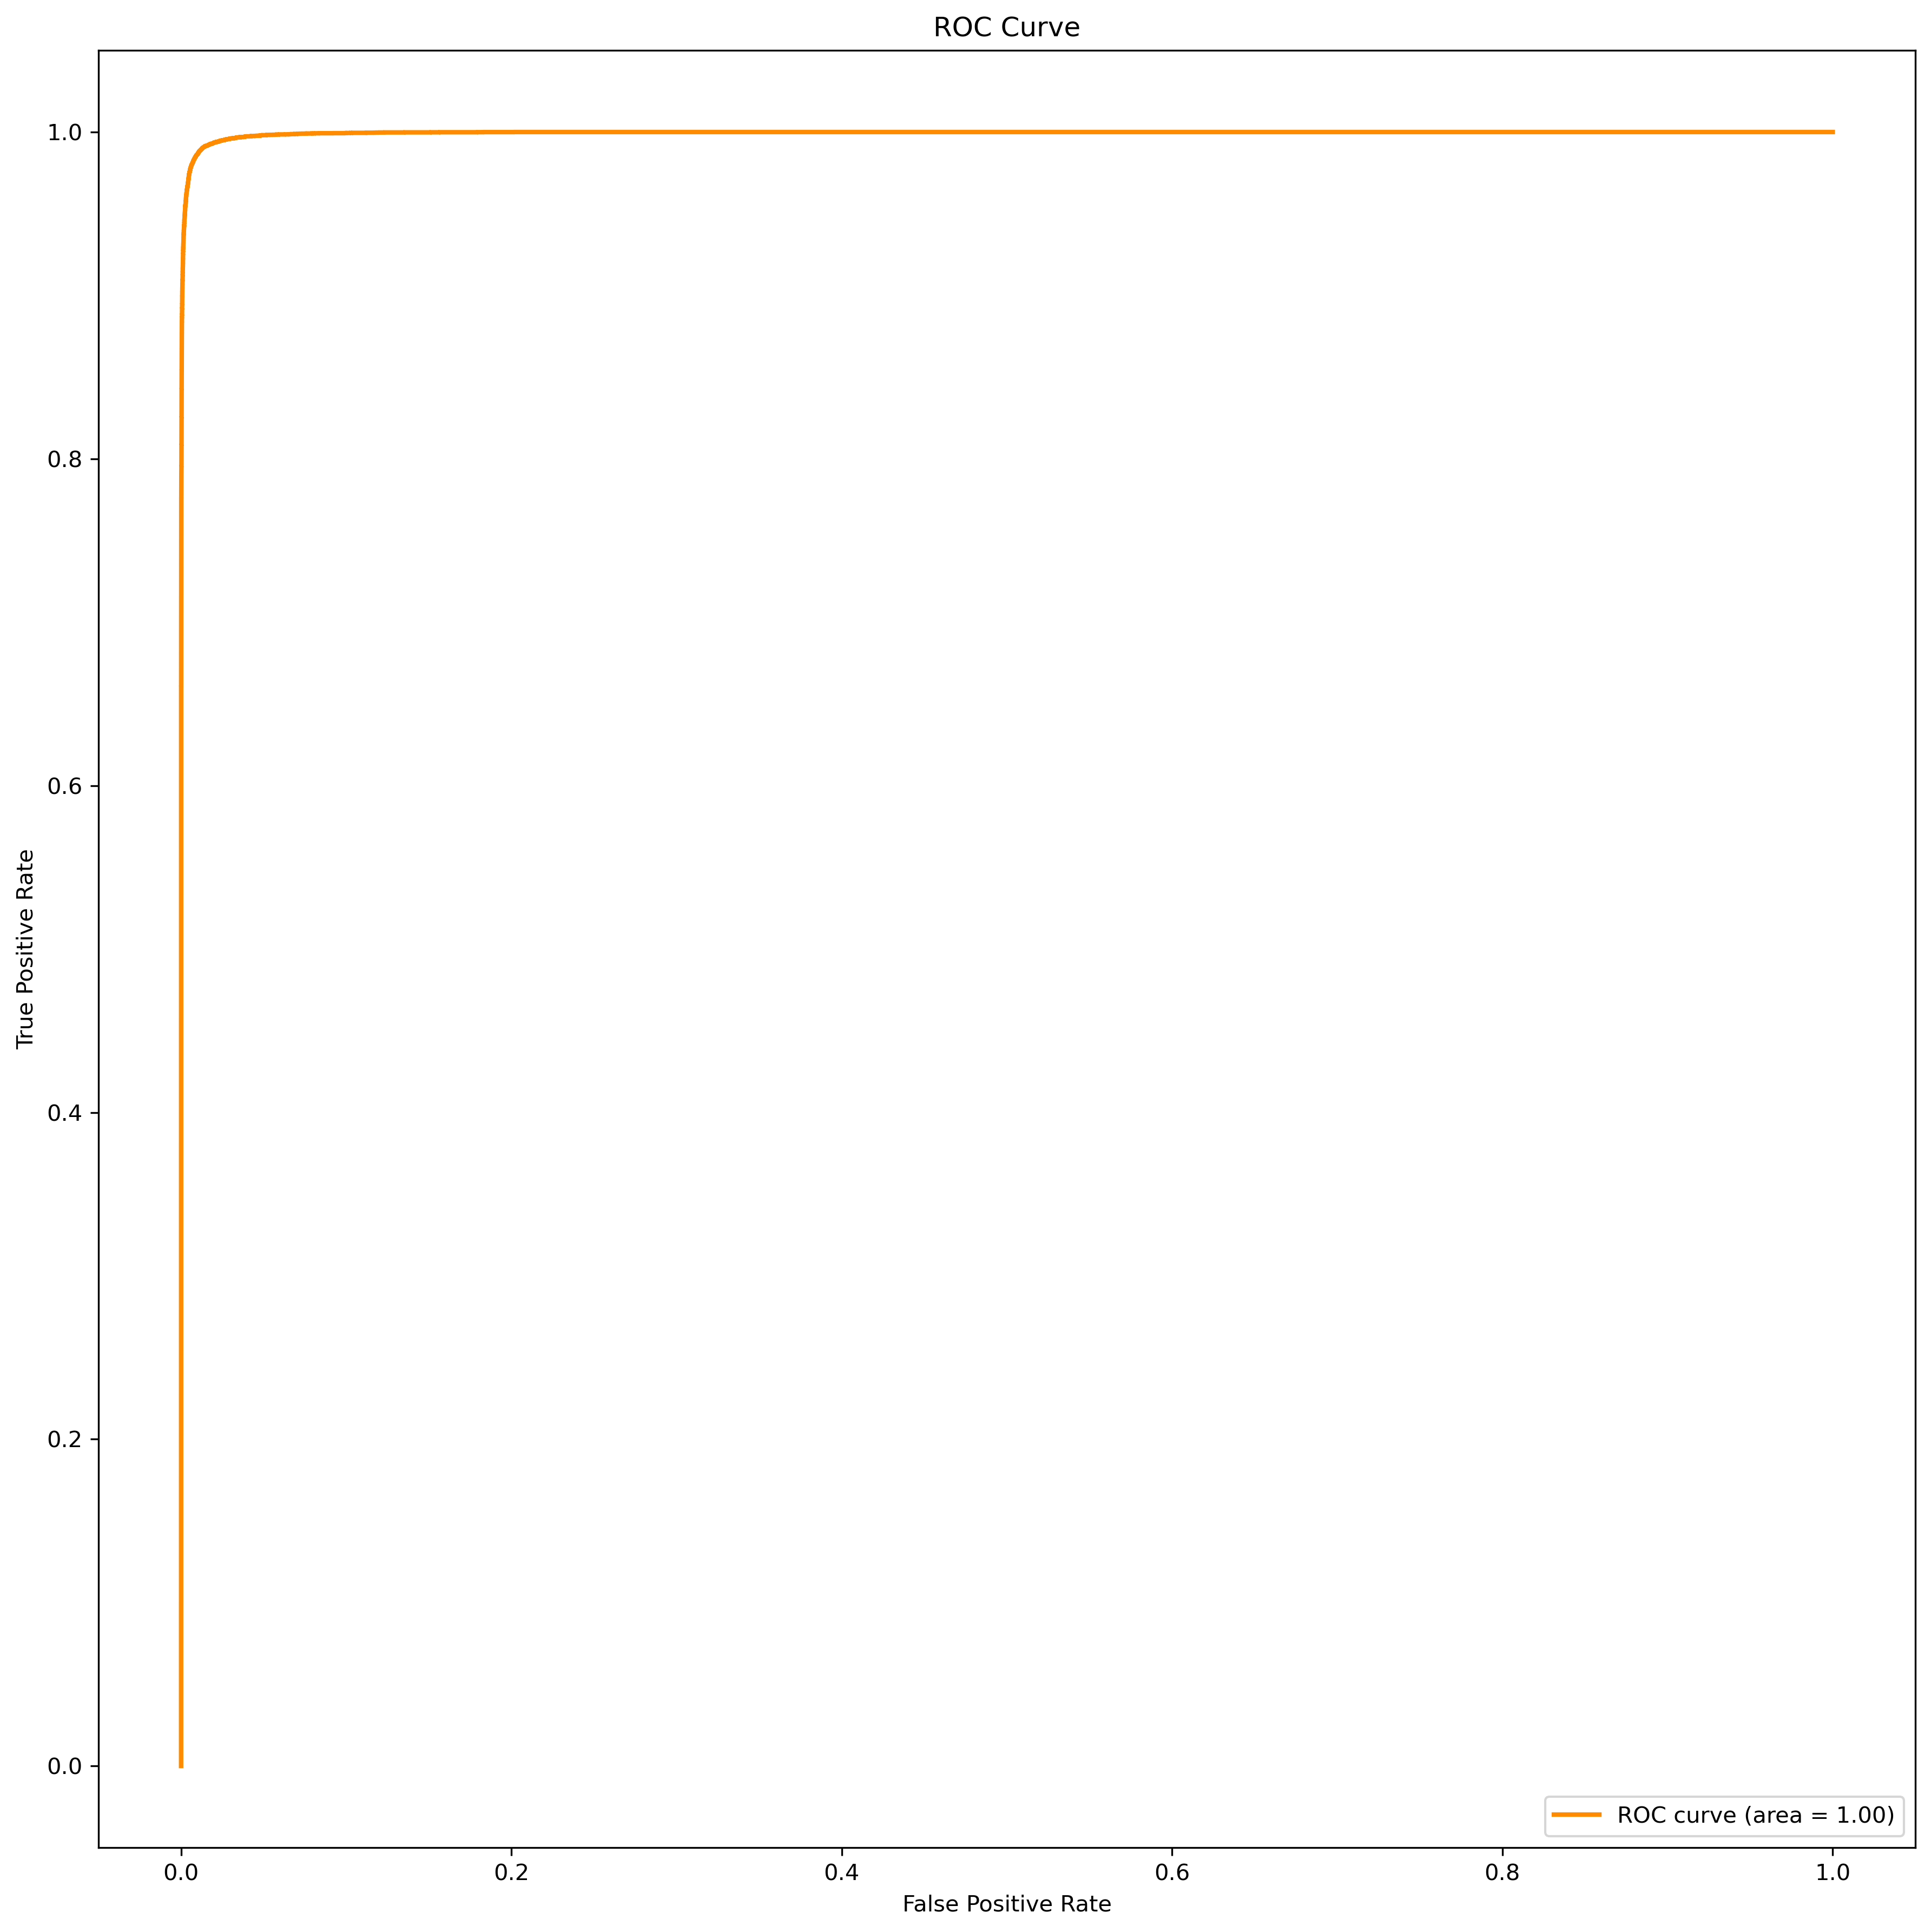

Training metrics: odict_keys(['error', 'logloss', 'auc'])
Validation metrics: odict_keys(['error', 'logloss', 'auc'])


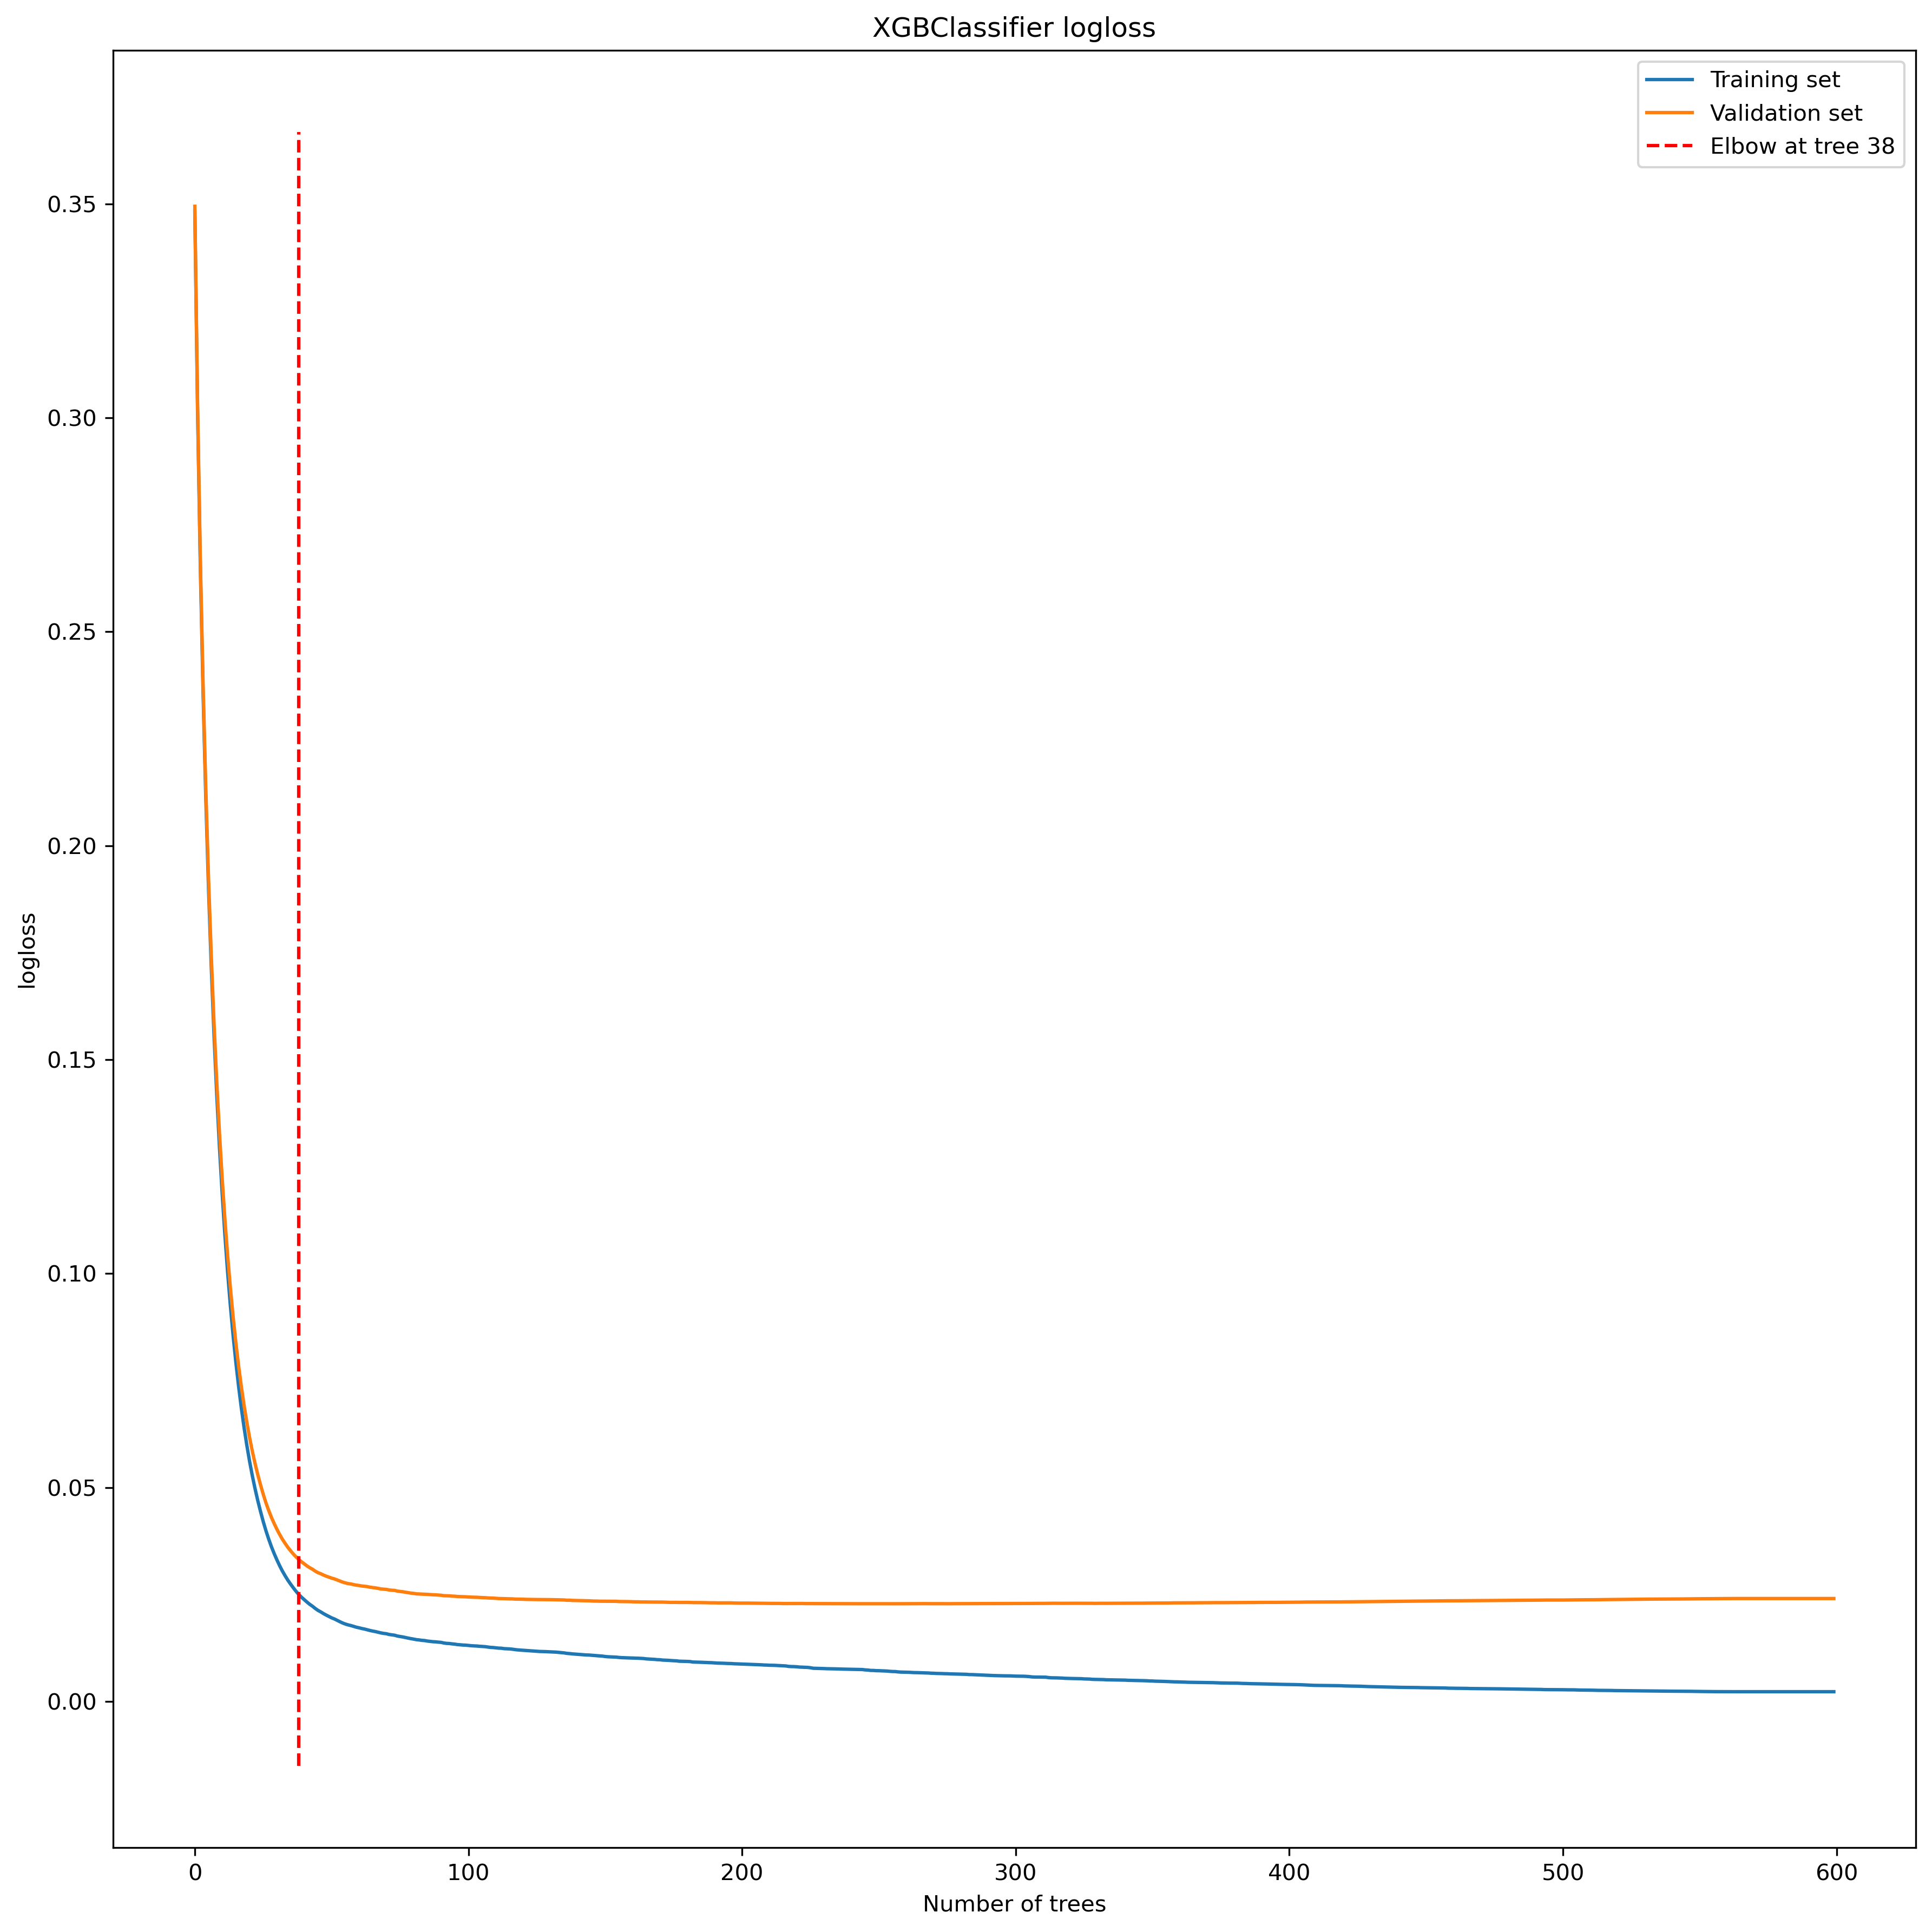

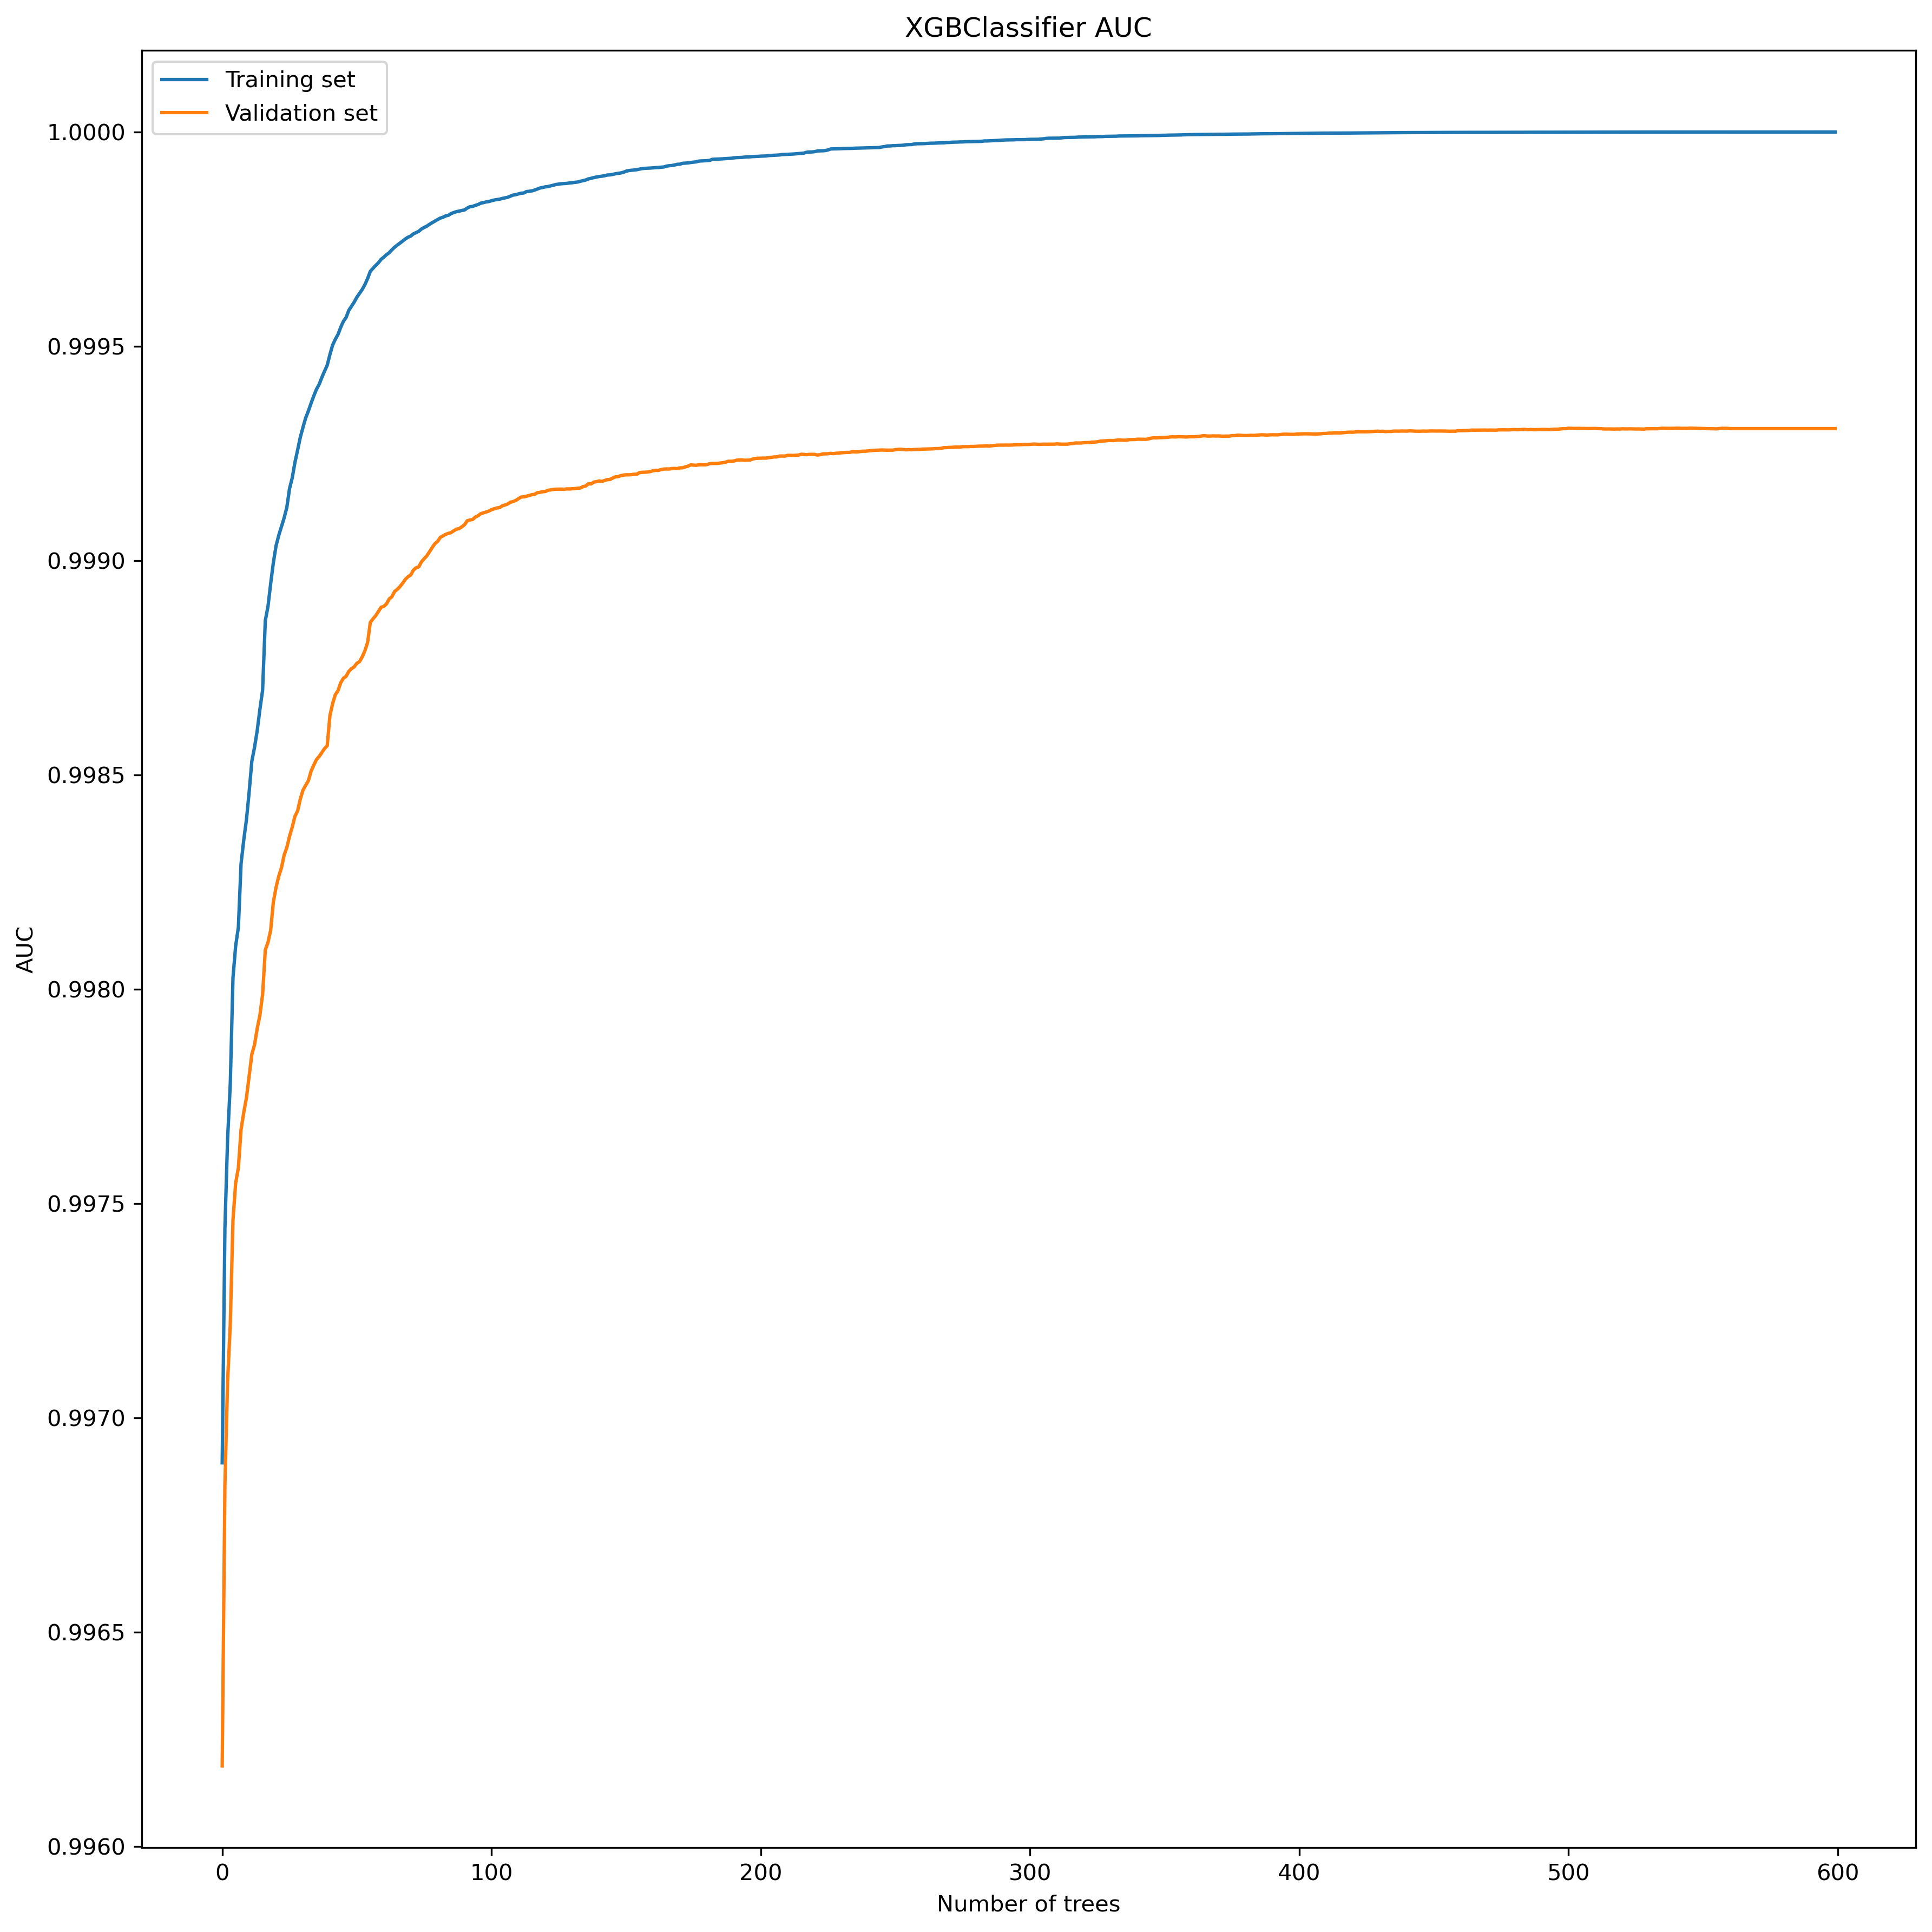

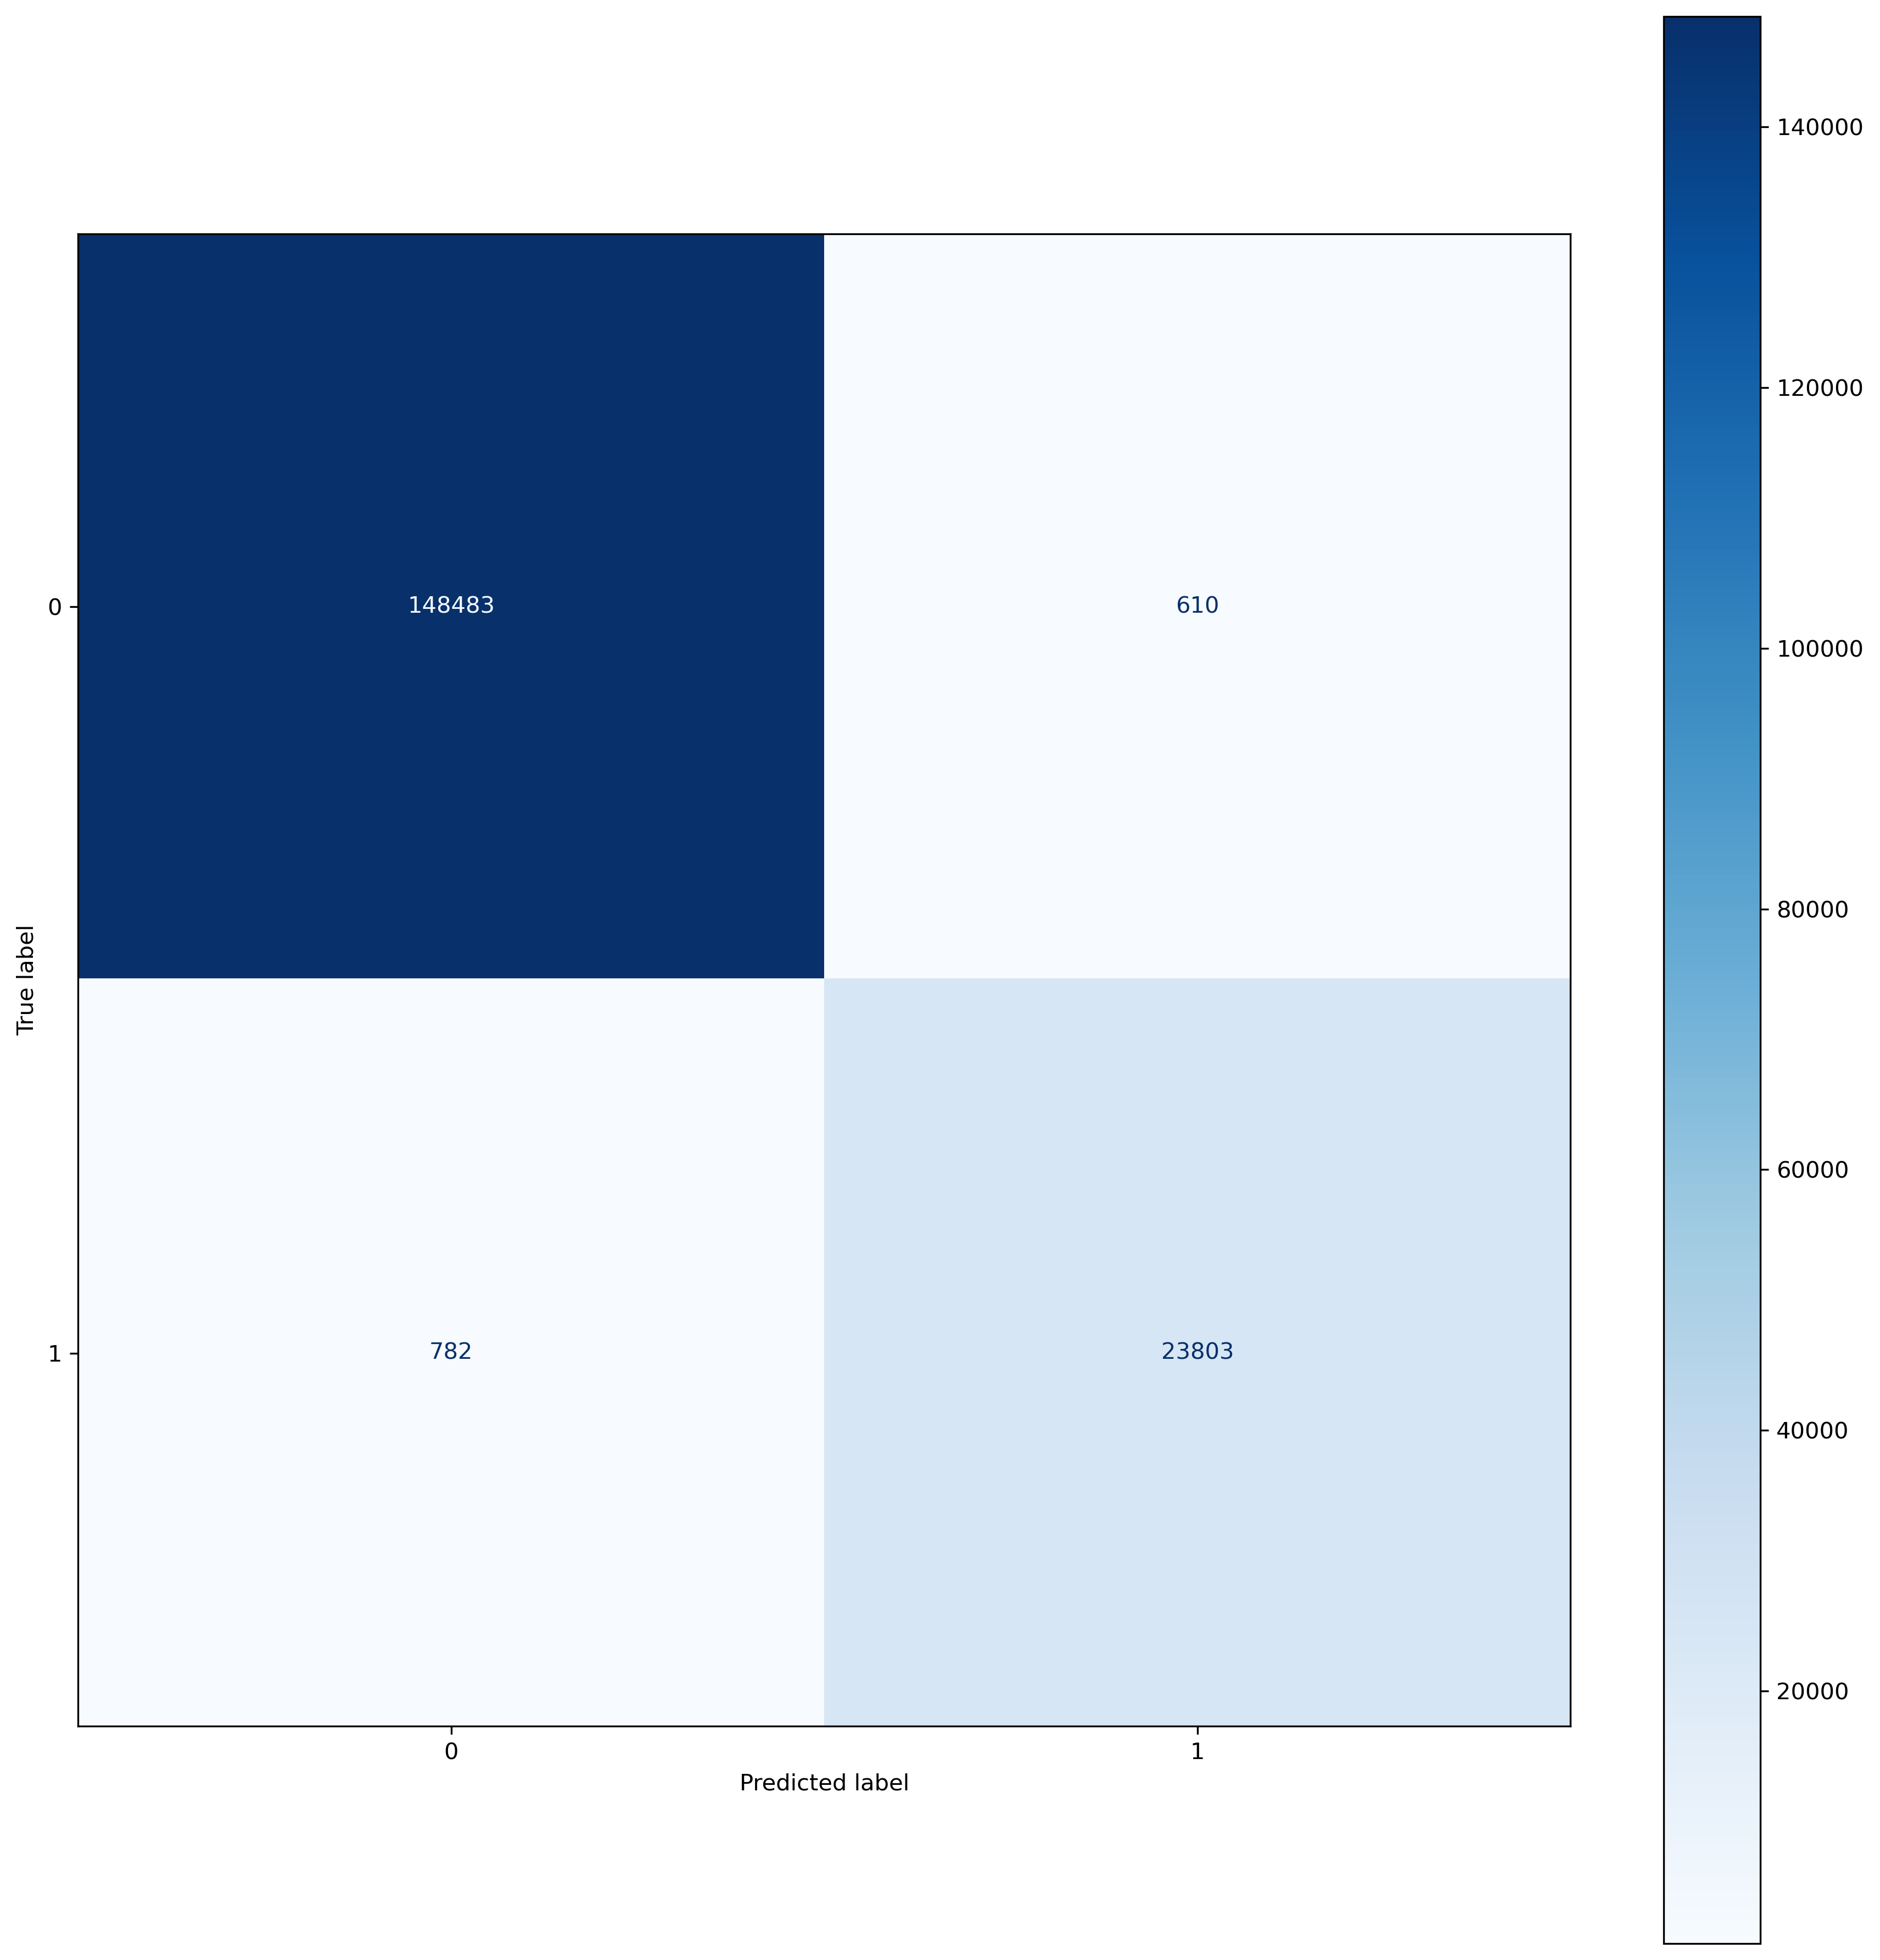

In [40]:
ValidateModel_advanced(X_test, Y_test, model)

## XGBoost Tuning

In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, log_loss

def FETA_Score(estimator, X, y):
    # Getting predictions
    y_pred = estimator.predict(X)
    y_pred_proba = estimator.predict_proba(X)
    
    # Calculating precision
    precision = precision_score(y, y_pred)
    
    # Calculating recall
    recall = recall_score(y, y_pred)
    
    # Calculating F1-score
    f1 = f1_score(y, y_pred)
    
    # Calculating FPR
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    # Calculating Log Loss
    logloss = log_loss(y, y_pred_proba)
    
    # Estimating overfitting
    train_score = estimator.score(X_train, y_train) 
    validation_score = estimator.score(X, y) 
    overfitting = train_score - validation_score
    
    # Assigning weights
    w_precision = 0.1     # Precision
    w_recall = 0.1        # Recall
    w_f1 = 0.6            # F1
    w_fpr = -0.0          # Negative because lower FPR is better
    w_logloss = -0.0      # Negative because lower log loss is better
    w_overfitting = -0.2  # Negative because lower overfitting is better
    
    #w_precision = 0.0     # Precision
    #w_recall = 0.5        # Recall
    #w_f1 = 0.5            # F1
    #w_fpr = -0.0          # Negative because lower FPR is better
    #w_logloss = -0.1      # Negative because lower log loss is better
    #w_overfitting = -0.0  # Negative because lower overfitting is better
    
    # Assigning weights
    #w_precision = 0.1     # Precision
    #w_recall = 0.1        # Recall
    #w_f1 = 0.4            # F1
    #w_fpr = -0.1          # Negative because lower FPR is better
    #w_logloss = -0.1      # Negative because lower log loss is better
    #w_overfitting = -0.5  # Negative because lower overfitting is better
    
    # Combining metrics with weights
    combined_score = (w_precision * precision + w_recall * recall + w_f1 * f1 + w_fpr * fpr + w_overfitting * overfitting)
    
    return combined_score


In [31]:
xgb_tuning = True

if xgb_tuning:
    from xgboost import XGBClassifier
    from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
    import pandas as pd

    # Assuming df is your DataFrame and class_map maps your classes
    labels = df['label'].apply(lambda x: class_map[x])
    features = df.drop('label', axis=1).copy()

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels)

    params = {
        "max_depth": 9,
        "eta": 0.15,
        "objective": "binary:logistic",
        "tree_method": "gpu_hist",
        "min_child_weight": 2.0,
        "subsample": 0.6,
        "sampling_method": "gradient_based",
        "alpha": 0,
        "gamma": 0.1,
        "lambda": 1.0,
        "max_delta_step": 0,
        "grow_policy": "lossguide",
        "max_bin": 512,
        "n_estimators": 550,
        "eval_metric": ["error", "logloss", "auc"],
        "random_state": 7
    }
    
    params = {        
        "objective": "binary:logistic",
        "tree_method": "gpu_hist",
        "sampling_method": "gradient_based",
        "max_depth": 12, 
        "eta": 0.09787878787878787, 
        "min_child_weight": 1, 
        "subsample": 0.595959595959596, 
        "alpha": 0, 
        "gamma": 0.06060606060606061, 
        "lambda": 2.0707070707070705, 
        "max_delta_step": 0, 
        "grow_policy": "depthwise",
        "max_bin": 512,
        "n_estimators": 600, 
        #"scale_pos_weight": scale_pos_weight,
        "eval_metric": ["error", "logloss", "auc"],
        "random_state": 42  # Set the seed for each run
    }
    
    # XGBoost base model
    xgb = XGBClassifier(**params)
    
    # Grid of parameters to search    
    grid = {
        #'scale_pos_weight': [4, 4.5, 5, 5.2, 6.28, 6, 6.71],
        'max_depth': [8, 9, 10, 11, 12],
        'n_estimators': [200, 300, 500, 600],
        'scale_pos_weight': [6.35],
        # Add other parameters here if needed
    }
    

    # Stratified K-Folds cross-validator
    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=7)

    # Grid Search
    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=grid,
        cv=cv,
        #scoring='f1',  # You can change this to another scoring method if needed
        scoring=FETA_Score,  # Custom metric
        verbose=3,
        return_train_score=True
    )

    grid_search.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

    # Best estimator
    best_xgb = grid_search.best_estimator_

    # Results
    scores = pd.DataFrame(grid_search.cv_results_)


Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV 1/2] END max_depth=8, n_estimators=200, scale_pos_weight=6.35;, score=(train=0.764, test=0.750) total time=  29.7s
[CV 2/2] END max_depth=8, n_estimators=200, scale_pos_weight=6.35;, score=(train=0.762, test=0.748) total time=  29.5s
[CV 1/2] END max_depth=8, n_estimators=300, scale_pos_weight=6.35;, score=(train=0.776, test=0.758) total time=  32.5s
[CV 2/2] END max_depth=8, n_estimators=300, scale_pos_weight=6.35;, score=(train=0.776, test=0.758) total time=  32.4s
[CV 1/2] END max_depth=8, n_estimators=500, scale_pos_weight=6.35;, score=(train=0.787, test=0.765) total time=  37.5s
[CV 2/2] END max_depth=8, n_estimators=500, scale_pos_weight=6.35;, score=(train=0.787, test=0.765) total time=  37.6s
[CV 1/2] END max_depth=8, n_estimators=600, scale_pos_weight=6.35;, score=(train=0.790, test=0.767) total time=  40.8s
[CV 2/2] END max_depth=8, n_estimators=600, scale_pos_weight=6.35;, score=(train=0.790, test=0.767) total 

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       16.914908      0.127987        12.690130        0.002281   
1       19.629060      0.040044        12.822971        0.013162   
2       24.244570      0.100082        13.302819        0.008060   
3       27.238799      0.123323        13.844828        0.140809   
4       17.877738      0.158899        12.684275        0.076533   
5       20.358053      0.027396        12.812503        0.049462   
6       26.196701      0.179865        13.522734        0.039994   
7       29.601496      0.554530        13.963503        0.101051   
8       18.518099      0.046656        12.747298        0.038804   
9       21.668646      0.012043        13.220200        0.229971   
10      28.941271      0.319377        13.733095        0.109739   
11      32.027425      0.276286        14.151296        0.023917   
12      19.382023      0.001985        13.194281        0.329945   
13      23.094014      0.180970        13.068435

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,param_scale_pos_weight,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,16.914908,0.127987,12.690130,0.002281,8,200,6.35,"{'max_depth': 8, 'n_estimators': 200, 'scale_p...",0.750385,0.748375,0.749380,0.001005,20,0.763944,0.762258,0.763101,0.000843
1,19.629060,0.040044,12.822971,0.013162,8,300,6.35,"{'max_depth': 8, 'n_estimators': 300, 'scale_p...",0.758187,0.757554,0.757870,0.000316,18,0.775601,0.775685,0.775643,0.000042
2,24.244570,0.100082,13.302819,0.008060,8,500,6.35,"{'max_depth': 8, 'n_estimators': 500, 'scale_p...",0.765401,0.764811,0.765106,0.000295,14,0.787205,0.787460,0.787333,0.000127
3,27.238799,0.123323,13.844828,0.140809,8,600,6.35,"{'max_depth': 8, 'n_estimators': 600, 'scale_p...",0.767207,0.766540,0.766874,0.000334,11,0.790498,0.790221,0.790359,0.000139
4,17.877738,0.158899,12.684275,0.076533,9,200,6.35,"{'max_depth': 9, 'n_estimators': 200, 'scale_p...",0.756885,0.755333,0.756109,0.000776,19,0.773429,0.773337,0.773383,0.000046
5,20.358053,0.027396,12.812503,0.049462,9,300,6.35,"{'max_depth': 9, 'n_estimators': 300, 'scale_p...",0.763093,0.761775,0.762434,0.000659,16,0.783723,0.782789,0.783256,0.000467
6,26.196701,0.179865,13.522734,0.039994,9,500,6.35,"{'max_depth': 9, 'n_estimators': 500, 'scale_p...",0.767632,0.766975,0.767303,0.000328,9,0.792438,0.791993,0.792216,0.000222
7,29.601496,0.554530,13.963503,0.101051,9,600,6.35,"{'max_depth': 9, 'n_estimators': 600, 'scale_p...",0.769030,0.768487,0.768758,0.000272,7,0.794992,0.795045,0.795018,0.000026
8,18.518099,0.046656,12.747298,0.038804,10,200,6.35,"{'max_depth': 10, 'n_estimators': 200, 'scale_...",0.760766,0.759520,0.760143,0.000623,17,0.780471,0.779866,0.780169,0.000302
9,21.668646,0.012043,13.220200,0.229971,10,300,6.35,"{'max_depth': 10, 'n_estimators': 300, 'scale_...",0.765954,0.764685,0.765320,0.000634,13,0.788979,0.788405,0.788692,0.000287


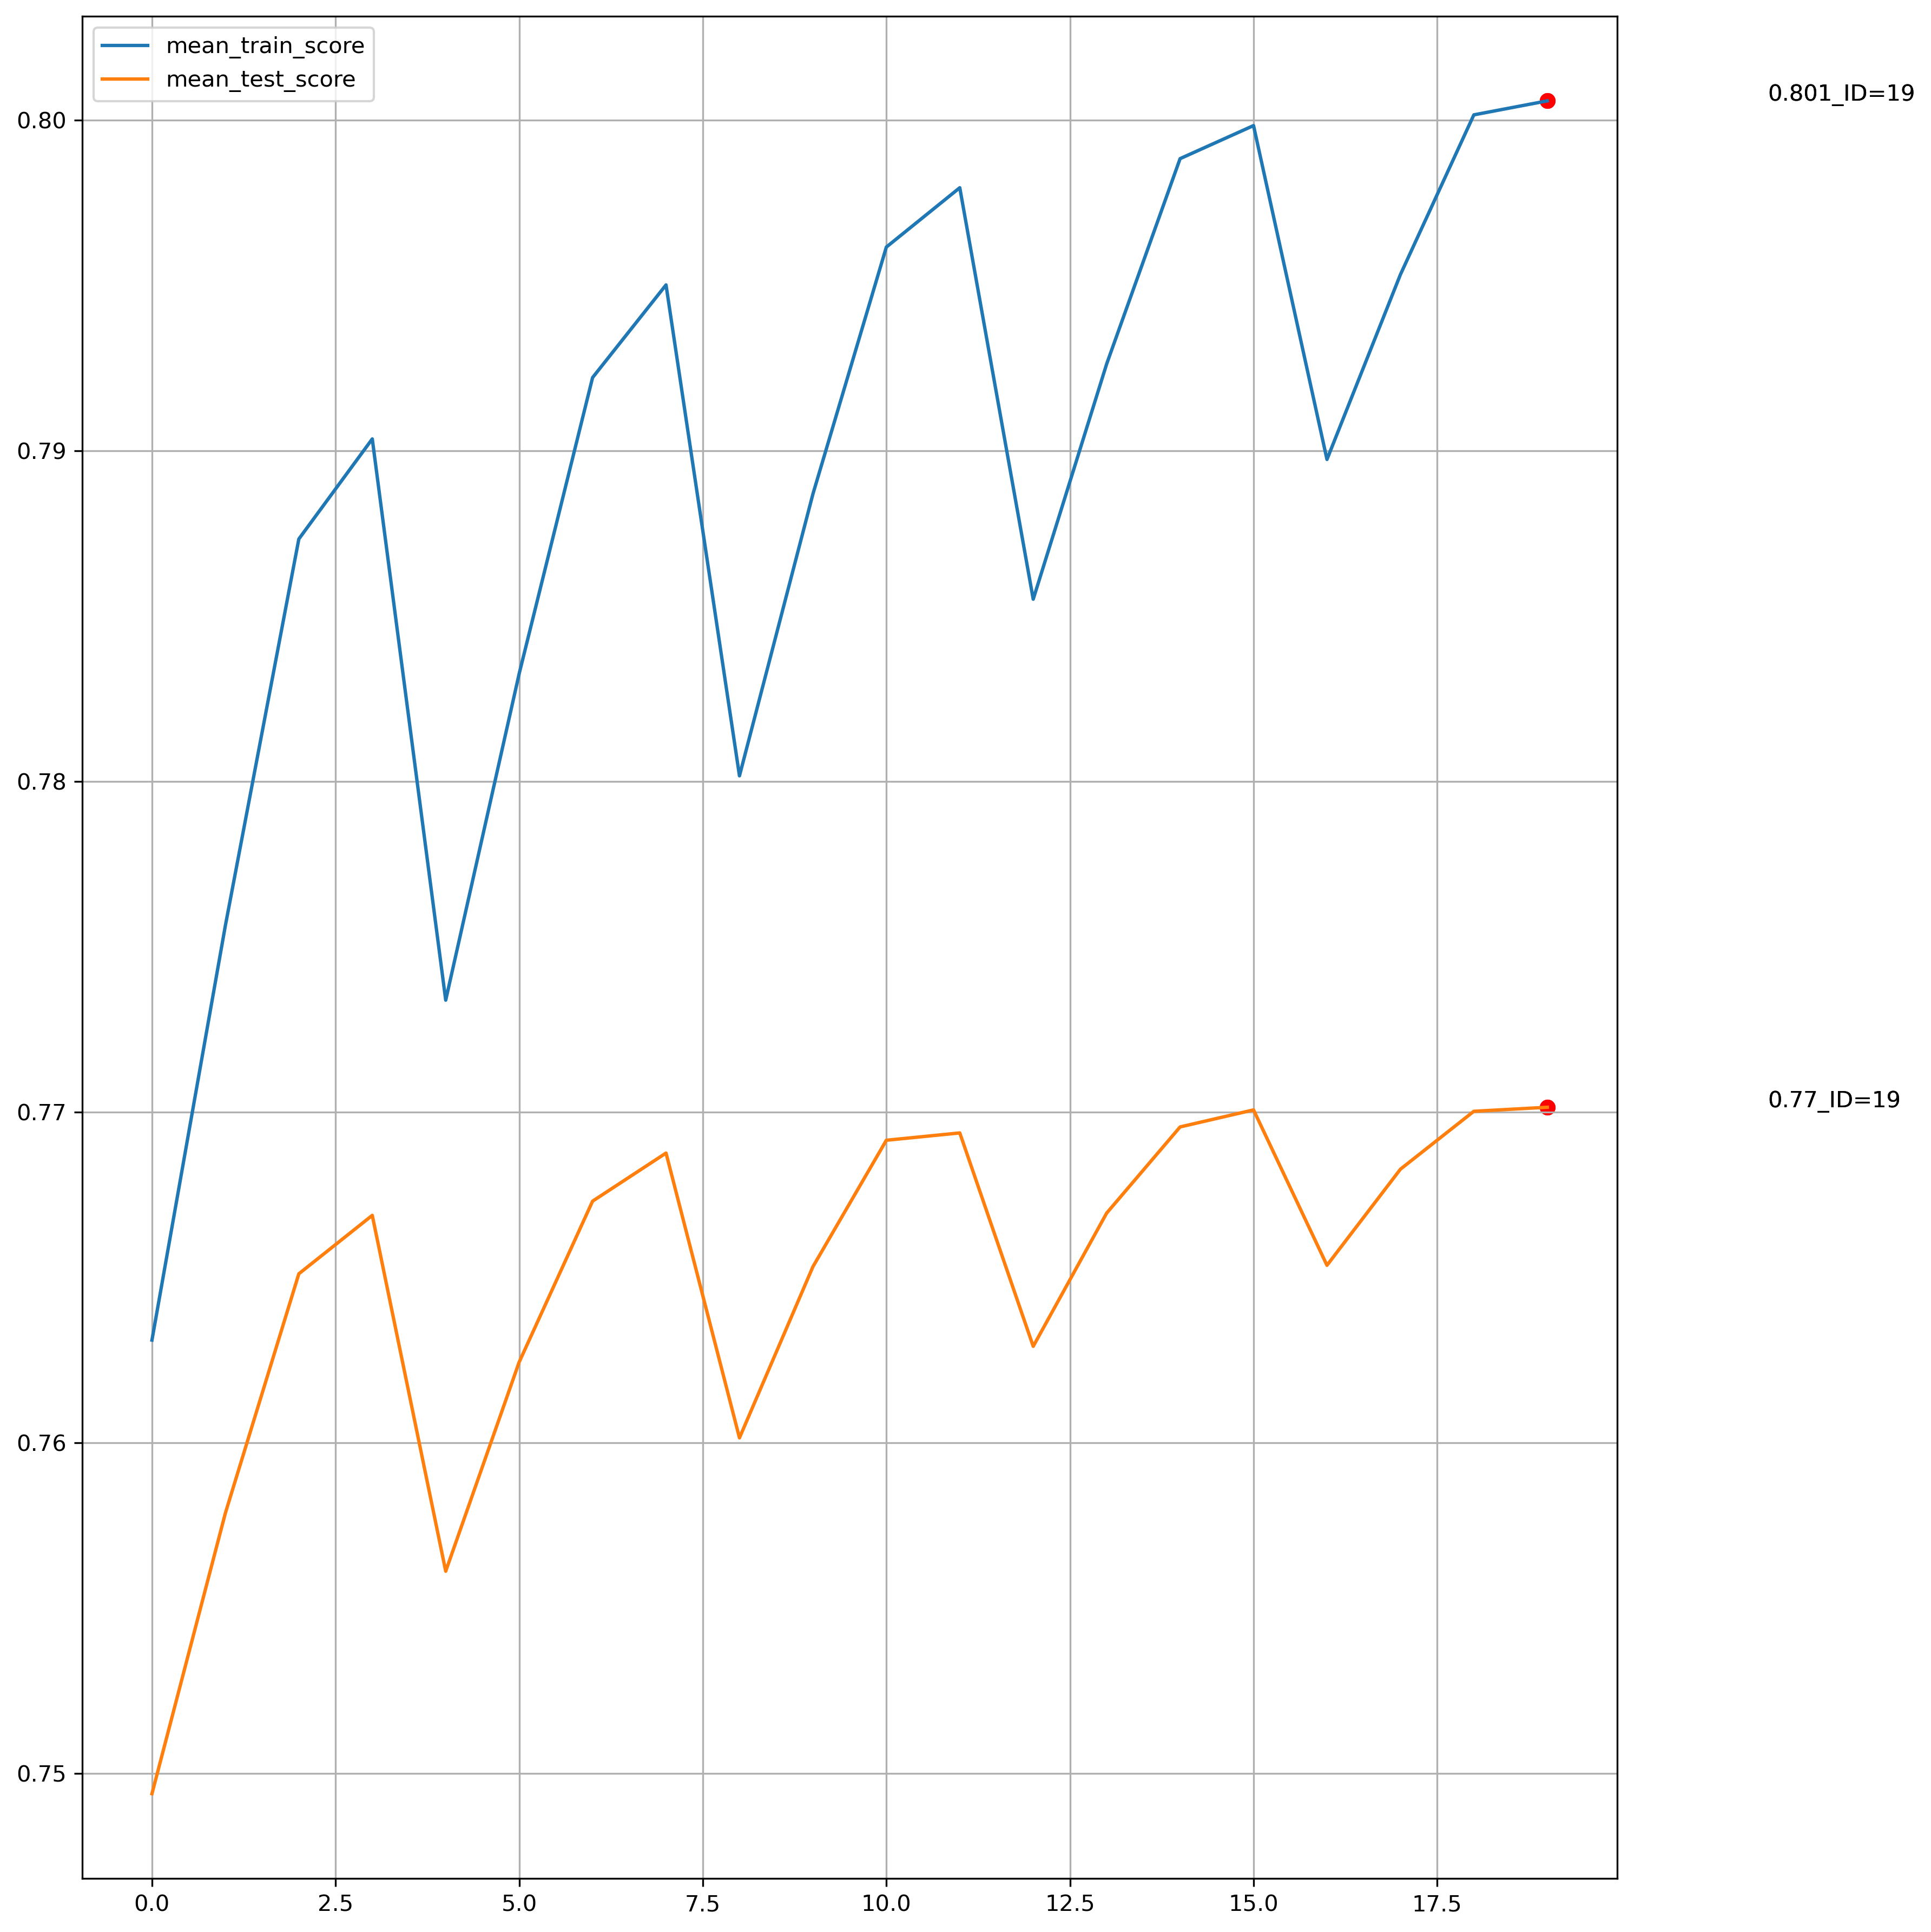

In [32]:
if xgb_tuning: 
    DisplayTuningGraph(scores)
    scores
scores

# SHAP

In [18]:
import shap

# Create an explainer object
explainer = shap.Explainer(model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

import pickle
pickle.dump(shap_values, open("shap/shap_values_xgb_malware.pkl", "wb"))

2024-05-26 14:05:23.960095: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 14:05:23.960263: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 14:05:24.004875: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-26 14:05:24.075342: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-26 14:05:24.997742: W tensorflow/compiler/tf2

FileNotFoundError: [Errno 2] No such file or directory: 'shap/shap_values_xgb_malware.pkl'

## Load shap values

In [ ]:
# load the values to start from here
import pickle
import shap
shap_values = pickle.load(open("shap/shap_values_xgb_malware.pkl", "rb"))

## Summary plot all features

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

feature_names = X_test.columns

# Calculate mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_values).mean(axis=0)

# Sort features by mean absolute SHAP values in descending order
sorted_indices = np.argsort(mean_shap_values)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_mean_shap_values = mean_shap_values[sorted_indices]

# Create a horizontal bar plot
plt.figure(figsize=(12, 22))
plt.barh(sorted_feature_names[::-1], sorted_mean_shap_values[::-1], height=0.8, color=plt.cm.cividis(sorted_mean_shap_values[::-1]))

# Add title and axis labels
plt.title('Feature Importance - SHAP Summary', fontsize=16, fontweight='bold')
plt.xlabel('Mean Absolute SHAP Value', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')

# Add values on each bar
for i, value in enumerate(sorted_mean_shap_values[::-1]):
    plt.text(value, i, f'{value:.2f}', ha='left', va='center', fontsize=10, fontweight='bold')

# Invert y-axis for better visualization
plt.gca().invert_yaxis()

# Remove extra space between the top of the plot and the first bar
plt.gca().set_ylim(-0.5, len(sorted_feature_names))

plt.tight_layout()

plt.savefig("shap/shap_summary_bar_xgb_malware.pdf")
plt.show()




## Summary plot top 10
features

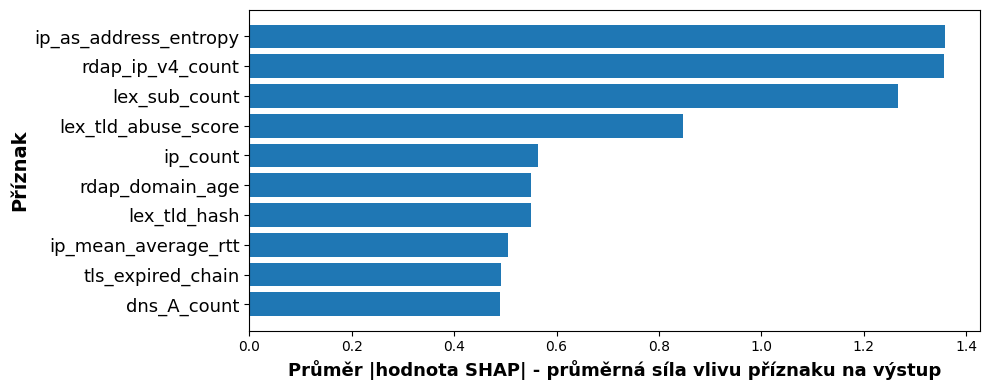

In [40]:
feature_names = X_test.columns
# Calculate mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_values).mean(axis=0)

# Sort features by mean absolute SHAP values in descending order
sorted_indices = np.argsort(mean_shap_values)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_mean_shap_values = mean_shap_values[sorted_indices]

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
bars = plt.barh(sorted_feature_names[:10], sorted_mean_shap_values[:10], height=0.8)


# # Annotate bars with feature names
# for i, bar, feature_name, mean_shap in zip(range(0,10), bars, sorted_feature_names[:10], sorted_mean_shap_values[:10]):
#     if i == 0:
#         plt.text(0.48, bar.get_y() + bar.get_height() / 2, f'{feature_name}: {mean_shap:.2f}', va='center', ha='center', fontsize=15, color='black')
#     elif i == 1:
#         plt.text(0.51, bar.get_y() + bar.get_height() / 2, f'{feature_name}: {mean_shap:.2f}', va='center', ha='center', fontsize=15, color='black')
#     elif i == 2:
#         plt.text(0.44, bar.get_y() + bar.get_height() / 2, f'{feature_name}: {mean_shap:.2f}', va='center', ha='center', fontsize=15, color='black')
#     elif i == 3:
#         plt.text(0.53, bar.get_y() + bar.get_height() / 2, f'{feature_name}: {mean_shap:.2f}', va='center', ha='center', fontsize=15, color='black')
#     elif i == 4:
#         plt.text(0.37, bar.get_y() + bar.get_height() / 2, f'{feature_name}: {mean_shap:.2f}', va='center', ha='center', fontsize=15, color='black')
#     elif i == 5:
#         plt.text(0.40, bar.get_y() + bar.get_height() / 2, f'{feature_name}: {mean_shap:.2f}', va='center', ha='center', fontsize=15, color='black')
#     elif i == 6:
#         plt.text(0.31, bar.get_y() + bar.get_height() / 2, f'{feature_name}: {mean_shap:.2f}', va='center', ha='center', fontsize=15, color='black')
#     elif i == 7:
#         plt.text(0.64, bar.get_y() + bar.get_height() / 2, f'{feature_name}: {mean_shap:.2f}', va='center', ha='center', fontsize=15, color='black')
#     elif i == 8:
#         plt.text(0.35, bar.get_y() + bar.get_height() / 2, f'{feature_name}: {mean_shap:.2f}', va='center', ha='center', fontsize=15, color='black')
#     else:
#         plt.text(0.66, bar.get_y() + bar.get_height() / 2, f'{feature_name}: {mean_shap:.2f}', va='center', ha='center', fontsize=15, color='black')

plt.xlabel('Průměr |hodnota SHAP| - průměrná síla vlivu příznaku na výstup', fontsize=13, fontweight='bold')
plt.ylabel('Příznak', fontsize=14, fontweight='bold')
plt.yticks(fontsize=13)

# plt.yticks([]) #hide labels


# Invert y-axis for better visualization
plt.gca().invert_yaxis()


plt.tight_layout()

plt.savefig("shap/shap_top10_bar_xgb_malware.pdf")
plt.savefig("shap/shap_top10_bar_xgb_malware.png")
plt.show()

## Summary plot - violin

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


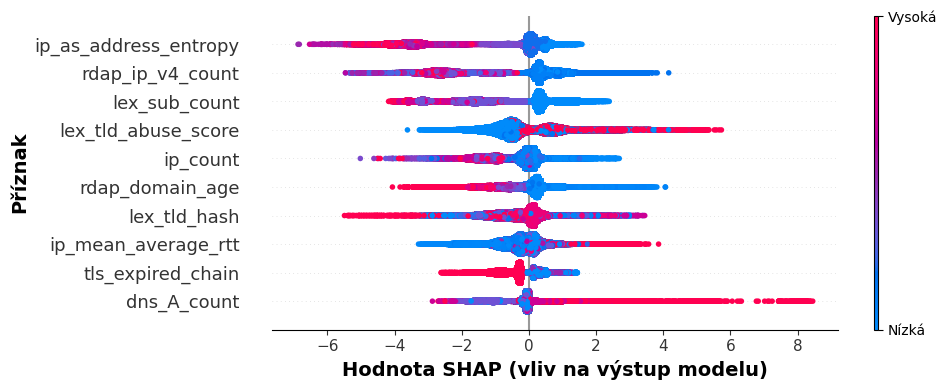

In [41]:
shap.summary_plot(shap_values, X_test, plot_type="dot", plot_size=[10,4], max_display=10, show=False, color_bar=False,
                  color_bar_label='Hodnota příznaku')

plt.xlabel('Hodnota SHAP (vliv na výstup modelu)', fontsize=14, fontweight='bold')
plt.ylabel('Příznak', fontsize=14, fontweight='bold')
plt.yticks(fontsize=13)

# Modify color bar labels
color_bar = plt.colorbar(aspect=80)
color_bar.set_ticks([color_bar.vmin, color_bar.vmax])  # Set ticks to min and max values of color bar
color_bar.set_ticklabels(['Nízká', 'Vysoká'])  # Set labels

plt.tight_layout()

plt.savefig("shap/shap_top10_dot_xgb_malware.pdf")
plt.savefig("shap/shap_top10_dot_xgb_malware.png")
plt.show()

## Force plot

In [73]:
index = 645
shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[index], X_test.iloc[index], out_names="malware")
# Saves as png 
shap.force_plot(explainer.expected_value, shap_values[index], X_test.iloc[index], show=False, matplotlib=True, out_names="malware").savefig("shap/shap_force_xgb_malware.pdf",format = "pdf",dpi = 300,bbox_inches = 'tight')

## Waterfall plot

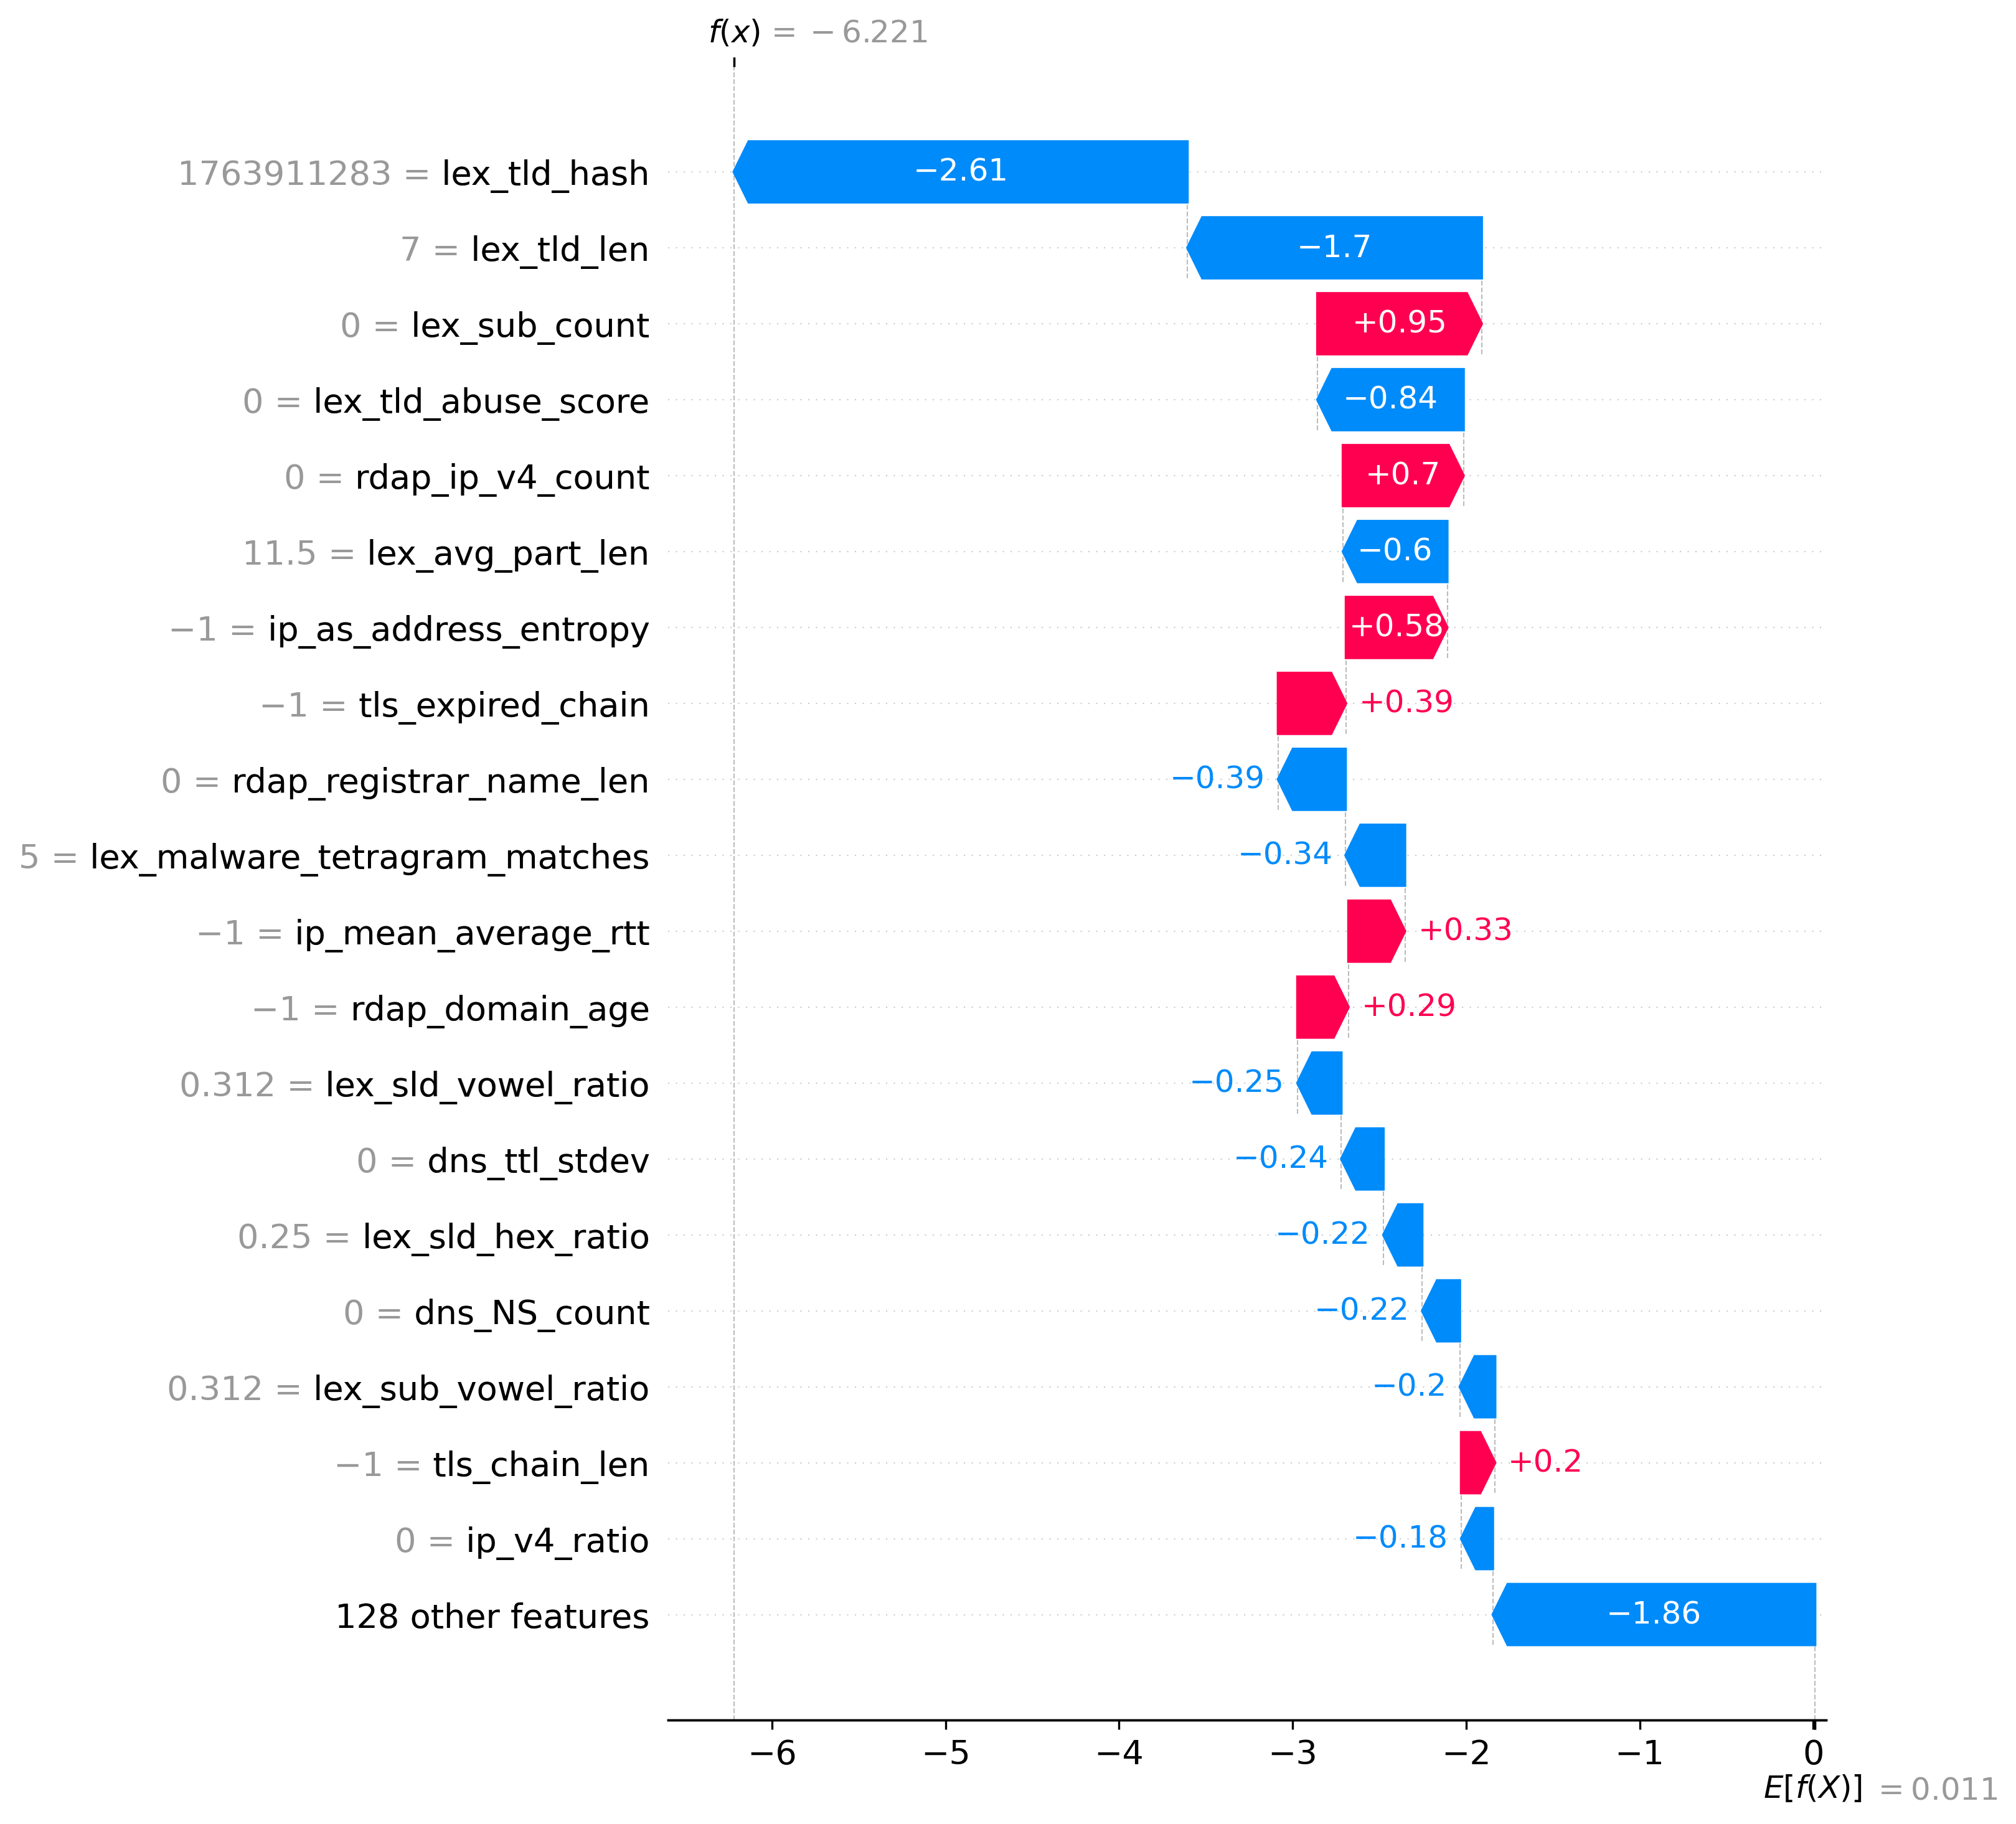

<Figure size 1920x1440 with 0 Axes>

In [71]:
shap.initjs()  # Initialize javascript for visualization (required for Jupyter notebook)

index = 645
# Create the waterfall plot
shap.waterfall_plot(shap.Explanation(values=shap_values[index],
                                      base_values=explainer.expected_value,
                                      data=X_test.iloc[index],
                                      feature_names=X_test.columns.tolist()), 
                    max_display=20)  # Adjust max_display as needed
plt.rcParams["figure.dpi"] = 300
# plt.savefig("shap/shap_waterfall_xgb_malware.pdf")
# plt.savefig("shap/shap_waterfall_xgb_malware.png")
plt.show()

# Comparing SHAP and GAIN

In [37]:
for i in range(len(sorted_feature_names)):
    feature_name = sorted_feature_names[i]  # Assuming shap_values has feature names
    shap_value = sorted_mean_shap_values[i]
    print(f"Feature: {feature_name}, SHAP Value: {shap_value}")


Feature: ip_as_address_entropy, SHAP Value: 1.3593623638153076
Feature: rdap_ip_v4_count, SHAP Value: 1.3567843437194824
Feature: lex_sub_count, SHAP Value: 1.267419457435608
Feature: lex_tld_abuse_score, SHAP Value: 0.8469400405883789
Feature: ip_count, SHAP Value: 0.5637099146842957
Feature: rdap_domain_age, SHAP Value: 0.5494459271430969
Feature: lex_tld_hash, SHAP Value: 0.5493118166923523
Feature: ip_mean_average_rtt, SHAP Value: 0.5053572654724121
Feature: tls_expired_chain, SHAP Value: 0.4920952618122101
Feature: dns_A_count, SHAP Value: 0.4894273579120636
Feature: lex_tld_len, SHAP Value: 0.45912453532218933
Feature: rdap_time_from_last_change, SHAP Value: 0.4478760063648224
Feature: rdap_registrar_name_len, SHAP Value: 0.4132052958011627
Feature: rdap_registrar_name_hash, SHAP Value: 0.41011616587638855
Feature: ip_entropy, SHAP Value: 0.38541752099990845
Feature: dns_NS_count, SHAP Value: 0.38175392150878906
Feature: tls_chain_len, SHAP Value: 0.35885846614837646
Feature: dns

In [38]:
shap_top10_shap = {
    'ip_as_address_entropy': 1.3593623638153076, 'rdap_ip_v4_count': 1.3567843437194824,
    'lex_sub_count': 1.267419457435608, 'lex_tld_abuse_score': 0.8469400405883789,
    'ip_count': 0.5637099146842957, 'rdap_domain_age': 0.5494459271430969,
    'lex_tld_hash': 0.5493118166923523, 'ip_mean_average_rtt': 0.5053572654724121,
    'tls_expired_chain': 0.4920952618122101, 'dns_A_count': 0.4894273579120636
    }
shap_top10_gain = {
    'ip_as_address_entropy': 0.04669865220785141, 'rdap_ip_v4_count': 0.12485634535551071,
    'lex_sub_count': 0.21613064408302307, 'lex_tld_abuse_score': 0.010447622276842594,
    'ip_count': 0.004295581020414829, 'rdap_domain_age': 0.002758914139121771,
    'lex_tld_hash': 0.0009519003215245903, 'ip_mean_average_rtt': 0.0015089553780853748,
    'tls_expired_chain': 0.09580899775028229, 'dns_A_count': 0.07471185177564621
    }
gain_top10_gain = {
    'lex_sub_count': 0.21613064408302307, 'rdap_ip_v4_count': 0.12485634535551071, 
    'tls_expired_chain': 0.09580899775028229, 'dns_A_count': 0.07471185177564621, 
    'dns_SOA_count': 0.07040833681821823, 'ip_as_address_entropy': 0.04669865220785141,
    'ip_distinct_as_count': 0.04022142291069031, 'tls_with_policies_crt_count': 0.031828563660383224, 
    'tls_x509_anypolicy_crt_count': 0.020858848467469215, 'lex_www_flag': 0.0199197456240654
    }
gain_top10_shap = {
    'lex_sub_count': 1.2674194574356083, 'rdap_ip_v4_count': 1.3567843437194824, 
    'tls_expired_chain': 0.4920952618122101, 'dns_A_count': 0.4894273579120636, 
    'dns_SOA_count': 0.03697308897972107, 'ip_as_address_entropy': 1.3593623638153076, 
    'ip_distinct_as_count': 0.21939422190189362, 'tls_with_policies_crt_count': 0.00510436063632369, 
    'tls_x509_anypolicy_crt_count': 0.023874444887042046, 'lex_www_flag': 0.0949459969997406
    }

shap_top10_shap = dict(reversed(shap_top10_shap.items()))
shap_top10_gain = dict(reversed(shap_top10_gain.items()))
gain_top10_gain = dict(reversed(gain_top10_gain.items()))
gain_top10_shap = dict(reversed(gain_top10_shap.items()))

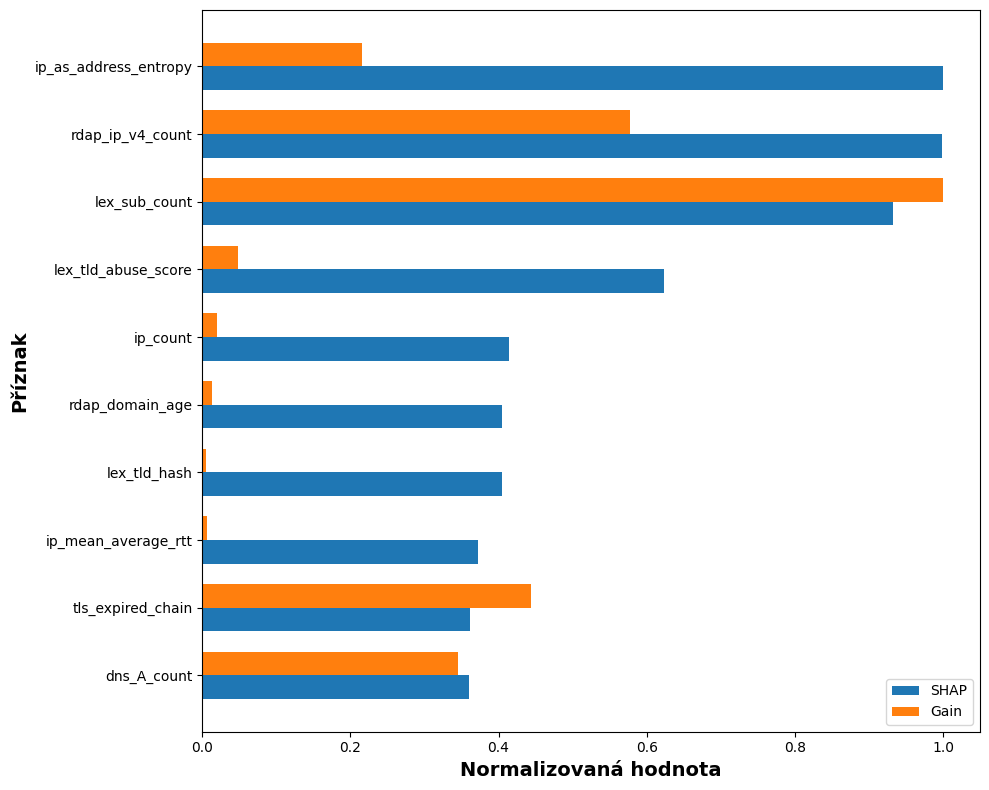

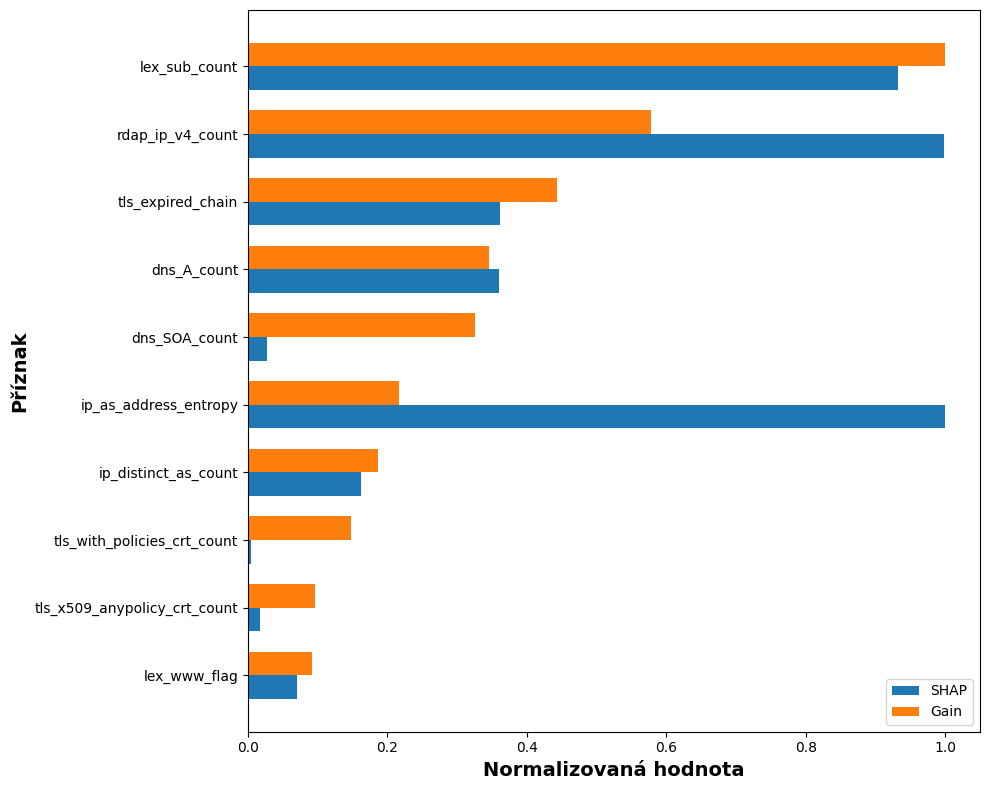

In [39]:
import matplotlib.pyplot as plt
import numpy as np

def plot_top10_features(name="SHAP"):
    # Extract feature names and corresponding values
    if name == "SHAP":
        features = list(shap_top10_shap.keys())
        shap_values = [shap_top10_shap[feature] for feature in features]
        gain_values = [shap_top10_gain[feature] for feature in features]
    else:
        features = list(gain_top10_gain.keys())
        shap_values = [gain_top10_shap[feature] for feature in features]
        gain_values = [gain_top10_gain[feature] for feature in features]
    
    # Normalize data
    shap_values /= np.max(np.abs(shap_values))
    gain_values /= np.max(np.abs(gain_values))

    
    # Set the height of the bars
    bar_height = 0.35
    
    # Set the position of the bars on the y-axis
    index = np.arange(len(features))
    
    # Plotting
    plt.figure(figsize=(10, 8))
    plt.barh(index, shap_values, bar_height, label='SHAP')
    plt.barh(index + bar_height, gain_values, bar_height, label='Gain')
    plt.ylabel('Příznak', fontsize=14, fontweight='bold')
    plt.xlabel('Normalizovaná hodnota', fontsize=14, fontweight='bold')
    plt.yticks(index + bar_height / 2, features)
    plt.legend(loc='lower right')
    plt.tight_layout()
    if name == "SHAP":
        plt.savefig("shap/SHAP_GAIN_compare_by_SHAP.pdf")
        plt.savefig("shap/SHAP_GAIN_compare_by_SHAP.png")
    else:
        plt.savefig("shap/SHAP_GAIN_compare_by_GAIN.pdf")
        plt.savefig("shap/SHAP_GAIN_compare_by_GAIN.png")
    plt.show()

plot_top10_features()
plot_top10_features("GAIN")


# Tuning

## Random Search

In [7]:
#pip install cupy
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

import datetime
import time

# Define the parameter grid for random search
param_grid = {
    'max_depth': np.arange(8, 15),
    'eta': np.linspace(0.01, 0.2, 100),
    'min_child_weight': np.arange(1, 6),
    'subsample': np.linspace(0.5, 0.8, 100),
    'gamma': np.linspace(0, 0.3, 100),
    'lambda': np.linspace(0, 3, 100),
    'max_delta_step': np.arange(0, 3),
    'n_estimators': np.arange(500, 1200, 50) 
}

# Initialize XGBClassifier
xgb = XGBClassifier(
    objective="binary:logistic",
    device="gpu",
    tree_method="hist",
    sampling_method="gradient_based",
    grow_policy="depthwise",
    alpha=0,
    max_bin= 256,
    random_state=42
)

# Perform random search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=100,  # Number of random parameter settings that are sampled
    scoring='f1',  # You can change scoring metric based on your need
    cv=5,  # Cross-validation folds
    verbose=1,
    n_jobs=-1,
    error_score='raise'
)

# Print the current date and time
start_time = datetime.datetime.now()
print(f"Start Time: {start_time}")

# Fit the random search model
random_search.fit(X_train, y_train)  # X_train and y_train are your training data

# Get the best parameters
print("Best parameters found: ", random_search.best_params_)

# Get the best score
print("Best score found: ", random_search.best_score_)

# Print end time and duration
end_time = datetime.datetime.now()
print(f"End Time: {end_time}")
time_taken = end_time - start_time
print(f"Time Taken: {time_taken}")


Start Time: 2024-04-25 10:31:22.678160
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:33:16] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:33:16] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure th

XGBoostError: [10:33:57] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [10:33:57] /workspace/src/c_api/../data/../common/device_helpers.cuh:431: Memory allocation error on worker 0: std::bad_alloc: cudaErrorMemoryAllocation: out of memory
- Free memory: 868483072
- Requested memory: 1073741824

Stack trace:
  [bt] (0) /home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x77f79a) [0x7f0ea3b7f79a]
  [bt] (1) /home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x783994) [0x7f0ea3b83994]
  [bt] (2) /home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/lib/libxgboost.so(+0xb3737b) [0x7f0ea3f3737b]
  [bt] (3) /home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/lib/libxgboost.so(+0xb3d674) [0x7f0ea3f3d674]
  [bt] (4) /home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/lib/libxgboost.so(+0xb425c2) [0x7f0ea3f425c2]
  [bt] (5) /home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/lib/libxgboost.so(+0xb436ab) [0x7f0ea3f436ab]
  [bt] (6) /home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/lib/libxgboost.so(+0xb47453) [0x7f0ea3f47453]
  [bt] (7) /home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/lib/libxgboost.so(+0xb48301) [0x7f0ea3f48301]
  [bt] (8) /home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f0ea3860c79]



Stack trace:
  [bt] (0) /home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f0ea3f27f2a]
  [bt] (1) /home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f0ea3f485c9]
  [bt] (2) /home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f0ea3860c79]
  [bt] (3) /home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x46176c) [0x7f0ea386176c]
  [bt] (4) /home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f0ea38c54f7]
  [bt] (5) /home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f0ea3561ef0]
  [bt] (6) /lib64/libffi.so.8(+0x9056) [0x7f0ed2040056]
  [bt] (7) /lib64/libffi.so.8(+0x55ef) [0x7f0ed203c5ef]
  [bt] (8) /lib64/libffi.so.8(ffi_call+0x12e) [0x7f0ed203f3fe]



## Grid Search

In [16]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import pandas as pd
import datetime
import time

# Assuming df is your DataFrame and class_map maps your classes
labels = df['label'].apply(lambda x: class_map[x])
features = df.drop('label', axis=1).copy()

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels)

params = {
    "objective": "binary:logistic",
    "device": "gpu",
    "tree_method": "hist",
    "sampling_method": "gradient_based",
    "grow_policy": "depthwise",
    "eval_metric": ["error", "logloss", "auc"],
    "random_state": 42,
    "max_bin": 512,
    "max_delta_step": 0,   
    "alpha": 0,
}

# XGBoost base model
xgb = XGBClassifier(**params)

# Grid of parameters to search    
grid = {
    "lambda": [1.0, 2.0],     
    'n_estimators': [950, 1000, 1100],  # Number of trees
    'max_depth': [12, 13],  # Maximum depth of a tree
    'eta': [0.09, 0.1],  # Learning rate
    'min_child_weight': [1, 2],  # Minimum sum of instance weight needed in a child
    'subsample': [0.5, 0.6],  # Subsample ratio of the training instances
    'gamma': [0.05, 0.08],  # Minimum loss reduction required to make a further partition
}

# Stratified K-Folds cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

# Grid Search
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=grid,
    cv=cv,
    scoring='f1',
    verbose=3,
    return_train_score=True
)

# Print the current date and time
start_time = datetime.datetime.now()
print(f"Start Time: {start_time}")

grid_search.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the best score
print("Best score found: ", grid_search.best_score_)

# Print end time and duration
end_time = datetime.datetime.now()
print(f"End Time: {end_time}")
time_taken = end_time - start_time
print(f"Time Taken: {time_taken}")

Start Time: 2024-04-28 00:05:26.705371
Fitting 5 folds for each of 128 candidates, totalling 640 fits


/home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:06:35] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END eta=0.09, gamma=0.05, lambda=1.0, max_depth=12, min_child_weight=1, n_estimators=950, subsample=0.5;, score=(train=0.999, test=0.968) total time= 1.2min
[CV 2/5] END eta=0.09, gamma=0.05, lambda=1.0, max_depth=12, min_child_weight=1, n_estimators=950, subsample=0.5;, score=(train=0.999, test=0.965) total time=  56.9s
[CV 3/5] END eta=0.09, gamma=0.05, lambda=1.0, max_depth=12, min_child_weight=1, n_estimators=950, subsample=0.5;, score=(train=0.999, test=0.966) total time=  58.5s
[CV 4/5] END eta=0.09, gamma=0.05, lambda=1.0, max_depth=12, min_child_weight=1, n_estimators=950, subsample=0.5;, score=(train=0.999, test=0.967) total time=  57.0s
[CV 5/5] END eta=0.09, gamma=0.05, lambda=1.0, max_depth=12, min_child_weight=1, n_estimators=950, subsample=0.5;, score=(train=0.999, test=0.966) total time=  56.6s
[CV 1/5] END eta=0.09, gamma=0.05, lambda=1.0, max_depth=12, min_child_weight=1, n_estimators=950, subsample=0.6;, score=(train=0.999, test=0.966) total time=  58.0s
[CV 

# Bayesan Search

In [10]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import pandas as pd
import datetime
import time

from skopt import BayesSearchCV

# Assuming df is your DataFrame and class_map maps your classes
labels = df['label'].apply(lambda x: class_map[x])
features = df.drop('label', axis=1).copy()

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels)

params = {
    "objective": "binary:logistic",
    "device": "cuda",
    "tree_method": "hist",
    "sampling_method": "gradient_based",
    "grow_policy": "depthwise",
    "eval_metric": ["error", "logloss", "auc"],
    "random_state": 42,
    "max_bin": 64,
    "max_delta_step": 0,   
    "alpha": 0,
}

# XGBoost base model
xgb = XGBClassifier(**params)

# Grid of parameters to search    
grid = {
    'max_depth': (8, 15),
    'eta': (0.01, 0.2),
    'min_child_weight': (1, 6),
    'subsample': (0.5, 0.8),
    'gamma': (0, 0.3),
    'lambda': (0, 3),
    'max_delta_step': (0, 3),
    'n_estimators': (500, 1200)
}

# Stratified K-Folds cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

# Bayes
reg_bay = BayesSearchCV(estimator=xgb,
                    search_spaces=grid,
                    n_iter=50,
                    cv=5,
                    n_jobs=-1,
                    scoring='f1',
                    random_state=42)

# Print the current date and time
start_time = datetime.datetime.now()
print(f"Start Time: {start_time}")

reg_bay.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

# Get the best parameters
print("Best parameters found: ", reg_bay.best_params_)

# Get the best score
print("Best score found: ", reg_bay.best_score_)

# Print end time and duration
end_time = datetime.datetime.now()
print(f"End Time: {end_time}")
time_taken = end_time - start_time
print(f"Time Taken: {time_taken}")

Start Time: 2024-04-25 17:25:27.924320


/home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:27:51] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:27:51] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure th

XGBoostError: [18:54:47] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [18:54:47] /workspace/src/c_api/../data/../common/device_helpers.cuh:431: Memory allocation error on worker 0: std::bad_alloc: cudaErrorMemoryAllocation: out of memory
- Free memory: 1078919168
- Requested memory: 1073741824

Stack trace:
  [bt] (0) /home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x77f79a) [0x7feecbb7f79a]
  [bt] (1) /home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x783994) [0x7feecbb83994]
  [bt] (2) /home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/lib/libxgboost.so(+0xb3737b) [0x7feecbf3737b]
  [bt] (3) /home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/lib/libxgboost.so(+0xb3d674) [0x7feecbf3d674]
  [bt] (4) /home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/lib/libxgboost.so(+0xb425c2) [0x7feecbf425c2]
  [bt] (5) /home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/lib/libxgboost.so(+0xb436ab) [0x7feecbf436ab]
  [bt] (6) /home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/lib/libxgboost.so(+0xb47453) [0x7feecbf47453]
  [bt] (7) /home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/lib/libxgboost.so(+0xb48301) [0x7feecbf48301]
  [bt] (8) /home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7feecb860c79]



Stack trace:
  [bt] (0) /home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7feecbf27f2a]
  [bt] (1) /home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7feecbf485c9]
  [bt] (2) /home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7feecb860c79]
  [bt] (3) /home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x46176c) [0x7feecb86176c]
  [bt] (4) /home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7feecb8c54f7]
  [bt] (5) /home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7feecb561ef0]
  [bt] (6) /lib64/libffi.so.8(+0x9056) [0x7feefa822056]
  [bt] (7) /lib64/libffi.so.8(+0x55ef) [0x7feefa81e5ef]
  [bt] (8) /lib64/libffi.so.8(ffi_call+0x12e) [0x7feefa8213fe]



# Evolutionary Search

In [15]:
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn.model_selection import train_test_split, StratifiedKFold
import pandas as pd
import datetime
import time


# Assuming df is your DataFrame and class_map maps your classes
labels = df['label'].apply(lambda x: class_map[x])
features = df.drop('label', axis=1).copy()

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels)

params = {
    "objective": "binary:logistic",
    "device": "cuda",
    "tree_method": "hist",
    "sampling_method": "gradient_based",
    "grow_policy": "depthwise",
    "eval_metric": ["error", "logloss", "auc"],
    "random_state": 42,
    "max_bin": 512,
    "max_delta_step": 0,   
    "alpha": 0,
}

# XGBoost base model
xgb = XGBClassifier(**params)

# Grid of parameters to search    
grid = {
    'max_depth': Integer(8, 15),
    'eta': Continuous(0.01, 0.2, distribution='uniform'),
    'min_child_weight': Integer(1, 6),
    'subsample': Continuous(0.5, 0.8, distribution='uniform'),
    'gamma': Continuous(0, 0.3, distribution='uniform'),
    'lambda': Continuous(0, 3, distribution='uniform'),
    'max_delta_step': Integer(0, 3),
    'n_estimators': Integer(500, 1200)
}

# Stratified K-Folds cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

# Evolutionary algorithm
reg_evo = GASearchCV(estimator=xgb,
                    param_grid=grid,
                    population_size=1,
                    generations=10,
                    cv=5,
                    n_jobs=-1,
                    scoring='f1')

# Print the current date and time
start_time = datetime.datetime.now()
print(f"Start Time: {start_time}")

reg_evo.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", reg_evo.best_params_)

# Get the best score
print("Best score found: ", reg_evo.best_score_)

# Print end time and duration
end_time = datetime.datetime.now()
print(f"End Time: {end_time}")
time_taken = end_time - start_time
print(f"Time Taken: {time_taken}")


Start Time: 2024-04-27 23:54:05.167987


/home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/norbi/Documents/bp/odevzdany_kod/venv/lib64/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:56:36] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input 

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	1     	0.965775	0          	0.965775   	0.965775   


ValueError: Sample larger than population or is negative